# Paso 1: Setup general


Bloque básico de instalación de librerías y herramientas básicas necesarias para la ejecución. Este bloque DEBE EJECUTARSE SIEMPRE AL PRINCIPIO.

In [ ]:
!pip install PyDrive
!pip install fastparquet

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches
import statistics

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from collections import Counter
from itertools import groupby
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

from fastparquet import ParquetFile
from fastparquet import write

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

sns.set_theme()
sns.set_context("paper")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


# Paso 2: Conexión con Google Drive para recuperar los ficheros con los datos

Autorice el acceso con su ID de Google, pegue el enlace que aparece y presione "Enter"

In [ ]:
"""
Authenticate and create the PyDrive client
"""
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Paso 3: Importación de funciones auxiliares



Definición de las funciones auxiliares requeridas

In [ ]:


"""
load_npy_data: Función que permite cargar los datos almacenados en un fichero npy
"""
def load_npy_data(npy_file):
  dir = '/content/'+npy_file
  data = pd.DataFrame(np.load(dir))
  return data

"""
load_txt_data: Función que permite cargar los datos almacenados en un fichero txt
"""
def load_txt_data(txt_file):
  dir = '/content/'+txt_file
  data = pd.read_csv(dir, sep=",")
  return data

"""
load_csv_data: Función que permite cargar los datos almacenados en un fichero csv
"""
def load_csv_data(csv_file):
  dir = '/content/'+csv_file
  data = pd.read_csv(dir, header=None)
  return data

"""
save_file: Función que permite salvar datos
"""
def save_file(name, file):
  write(name, file, compression='GZIP')

"""
set_size_letters(): Función que permite modificar el tamaño letra a utilizar en los plots
"""
def set_size_letters(title, x_name, y_name, title_size = 20, x_size = 18, y_size = 18, active_legend = True, legend_size = 14):

  """
  Parameters:
    title (string): titulo del plot a representar

    x_name (string): nombre del eje x

    y_name (string): nombre del eje y

    active_legend (bool): indica si mostramos la leyenda o no. Por defecto True

    x_size, y_size, legend_size: tamaño de fuente de eje x, y, leyenda

  """

  plt.title(title, fontsize=title_size)
  plt.xlabel(x_name, fontsize=x_size)
  plt.ylabel(y_name, fontsize=y_size)
  if (active_legend == True):
    plt.legend(fontsize=legend_size)

"""
PlotDistancesToKnearestNeighbor: Función que devuelve la distancia con el K-vecino más cercano
"""
def PlotDistancesToKnearestNeighbor(data_vector, K):

  """
  Parameters:
    data_vector (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

    k: posición del k-esimo vecino más cercano

  """

  nbrs = NearestNeighbors(n_neighbors=K).fit(data_vector)
  distances, indices = nbrs.kneighbors(data_vector)
  distances = np.sort(distances, axis=0)
  distances = distances[:,K-1]
  plt.figure(figsize=(10,8))
  set_size_letters(f"Distancias al K-vecino más cercano (K={K})",
                   f"Points sorted according to distance of the {K}-th nearest neighbor",
                   f"{K}-th nearest neighbor distance")
  plt.plot(distances)
  #
  #plt.plot(min_dist)

"""
nearest_neighbor_distance: Función que devuelve la distancia con el vecino más cercano
"""
def nearest_neighbor_distance (data_vector, name_clustering):

  """
  Parameters:
    data_vector (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

    name_clustering (string): nombre de los datos representados, se utiliza
        para el titulo del plot realizado

  """

  nbrs = NearestNeighbors(n_neighbors=2).fit(data_vector)
  distances, indices = nbrs.kneighbors(data_vector)

  min_dist = np.sort(distances[:,1])

  plt.figure(figsize=(10,8))
  set_size_letters(f"Distancia al vecino más cercano: datos {name_clustering}", "nº muestra", "epsilon")
  plt.plot(min_dist)

"""
dbScan_nsamples: Función que reliza barrido dbscan con calculo de silueta
"""
def dbScan_nsamples(data, epsilon_vect, min_samples = 30, include_noise = False):
  """
  Parameters:

    data (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

    epsilon_vect (list): lista con los valores de epsilon
        para realizar el barrido (distancia mínima entre elementos
        para formar un cluster)

    min_samples (int): numero minimo de muestras para generar un cluster

    include_noise (bool): permite seleccionar si se quiere incluir el cluster
        de ruido en el cálculo de la silueta o no. Por defecto no se incluye.
        Se debe incluir cuando únicamente se detecta un cluster, para poder
        realizar la evaluación.
  """

  for epsilon in epsilon_vect:

    db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(data)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    silhouette_data = np.copy(data)
    noise_points = np.where(labels == -1)

    # delete noise cluster
    if (include_noise == False):
      silhouette_data = np.delete(silhouette_data, noise_points, axis=0)
      silhouette_labels = np.delete(labels, noise_points, axis=0)
    else:
      silhouette_labels = np.copy(labels)

    #calculate silhouette_score
    silhouette_avg = silhouette_score(silhouette_data, silhouette_labels)
    print(f"Epsilon = {epsilon}")
    print(f"N clusters: {n_clusters_}, Nº_noise_points = {n_noise_}")
    print(f"silhouette_score = {silhouette_avg} \r\n")

"""
ApplyDBScanToData: Función que permite seleccionar DBSCAN
"""
def ApplyDBScanToData (samples, epsilon, min_samples = 30):

  """
  Parameters:

    samples (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

    epsilon: int con el valor de epsilon (distancia mínima entre elementos
        para formar un cluster)

    min_samples (int): numero minimo de muestras para generar un cluster

    include_noise (bool): permite seleccionar si se quiere incluir el cluster
        de ruido en el cálculo de la silueta o no. Por defecto no se incluye.
        Se debe incluir cuando únicamente se detecta un cluster, para poder
        realizar la evaluación.

  Return:

    labels: lista con el cluster al que pertenece cada ejemplo de data. Cluster
        -1 significa ruido.
  """


  db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(samples)

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_

  # Number of clusters in labels, ignoring noise if present.
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)

  print(f"\nTest for epsilon = {epsilon}")
  print('Estimated number of clusters: %d' % n_clusters_)
  print('Estimated number of noise points: %d' % n_noise_)
  print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(samples, labels))


  return labels

def Plot2D (samples_2D, title, axes = {'x': 'x', 'y': 'y'}):

  """
  samples_2D (numpy.ndarray): array tipo embedding cuyo
        shape es (num_muestras, 2) ; 2 por las dos coordenadas

  title(string): titulo de la figura que se utiliza para el plot
  """

  df_samples_2D = pd.DataFrame(data=samples_2D, columns=[axes['x'], axes['y']])

  sns.set(font_scale=3)
  sns.set(rc={'figure.figsize':(10,10)})
  sns.relplot(data=df_samples_2D,
              x=axes['x'],
              y=axes['y'],
              height=10, legend="full", palette="bright")

  set_size_letters(title,
                   axes['x'],
                   axes['y'],
                   active_legend = False)
  plt.axis('equal')

def plot_2D_centroid_labels(df_centroids, ax):
    for index, row in df_centroids.iterrows():
      ax.text(row[0]+.5, row[1], 'C'+str(row[2].astype(int)), fontsize = 20, color='black', weight='semibold')

def plot_3D_centroid_labels(df_centroids, ax):
    for index, row in df_centroids.iterrows():
      ax.text(row[0]+.5, row[1], row[2], row[3].astype(int), fontsize = 20, color='black', weight='semibold')

def Plot2D_WithLabels (samples_2D, labels, title, axes = {'x': 'x', 'y': 'y'}, palette="bright", centroids_2D=None):

  """
  samples_2D (numpy.ndarray): array tipo embedding cuyo
        shape es (num_muestras, 2) ; 2 por las dos coordenadas

  labels (array): etiqueta perteneciente a cada muestra.

  title(string): titulo de la figura que se utiliza para el plot
  """

  # First we create the dataframe
  df_samples_2D_labeled = pd.DataFrame(data=samples_2D, columns=[axes['x'], axes['y']])

  # Then we add the labels column
  df_samples_2D_labeled['label'] = labels.tolist()

  if centroids_2D is not None:
    labels_centroid_aux = np.arange(len(centroids_2D), dtype=int)
    df_centroids_2D_labeled = pd.DataFrame(data=centroids_2D, columns=[axes['x'], axes['y']])
    df_centroids_2D_labeled['label'] = labels_centroid_aux.tolist()

  sns.set(font_scale=3)
  sns.set(rc={'figure.figsize':(10,10)})
  sns.relplot(data=df_samples_2D_labeled,
              x=axes['x'],
              y=axes['y'],
              hue="label", height=10, legend="full", palette=palette)

  if centroids_2D is not None:
    # First we plot the centroids
    sns.scatterplot(data=df_centroids_2D_labeled,
              x=axes['x'],
              y=axes['y'],
              hue="label",
              legend=False, palette=palette, s=100)

    # Then we plot their labels
    plot_2D_centroid_labels(df_centroids_2D_labeled, plt.gca())

  set_size_letters(title,
                   axes['x'],
                   axes['y'],
                   active_legend = False)
  plt.axis('equal')

def Plot3D (samples_3D, title, axes = {'x': 'x', 'y': 'y', 'z': 'z'}):

  """
  samples_3D (numpy.ndarray): array tipo embedding cuyo
        shape es (num_muestras, 3) ; 3 por las tres coordenadas

  title(string): titulo de la figura que se utiliza para el plot
  """

  df_samples_3D = pd.DataFrame(data=samples_3D, columns=[axes['x'], axes['y'], axes['z']])

  fig = px.scatter_3d(df_samples_3D,
                      x=axes['x'],
                      y=axes['y'],
                      z=axes['z'])

  fig.update_layout(scene_aspectmode='data')

  fig.update_layout(
    title_font_size=20,
    title={
        'text': title,
        'y': 0.9,
        'x': 0.05,
        'xanchor': 'left',
        'yanchor': 'top'})

  # tight layout
  fig.update_layout(
      autosize = True, #False,
      #width = 1200,
      #height = 800,
      margin = dict(l=50, r=0, b=10, t=30))

  fig.show()

def Plot3D_WithLabels (samples_3D, labels, title, axes = {'x': 'x', 'y': 'y', 'z': 'z'}, centroids_3D=None):

  """
  samples_3D (numpy.ndarray): array tipo embedding cuyo
        shape es (num_muestras, 3) ; 3 por las tres coordenadas

  labels (array): etiqueta perteneciente a cada muestra.

  title(string): titulo de la figura que se utiliza para el plot
  """

  # First we create the dataframe
  df_samples_3D_labeled = pd.DataFrame(data=samples_3D, columns=[axes['x'], axes['y'], axes['z']])

  # Then we add the labels column
  df_samples_3D_labeled['label'] = labels.tolist()
  df_samples_3D_labeled['label'] = df_samples_3D_labeled["label"].astype(str)

  if centroids_3D is not None:
    # Same applies for centroids when these are provided as an argument
    labels_centroid_aux = np.arange(len(centroids_3D), dtype=int)
    df_centroids_3D_labeled = pd.DataFrame(data=centroids_3D, columns=[axes['x'], axes['y'], axes['z']])
    df_centroids_3D_labeled['label'] = labels_centroid_aux.tolist()

    # We create an additional column with the dot size used for each type of sample
    size_no_centroid = np.ones(len(samples_3D)) * 10 # for regular samples
    size_centroid = np.ones(len(centroids_3D)) * 50 # for centroids
    size_col = np.append(size_no_centroid, size_centroid) # new col to be added to the dataframe

    # We also create another additional column with the labels for each type of sample
    no_es_centroide_aux = [' '] * len(samples_3D) # empty label for regular samples
    es_centroide_aux = []
    for i in range(len(centroids_3D)):
      es_centroide_aux.append('C%d' % i) # Ci label for centroid i
    centroid_col = no_es_centroide_aux + es_centroide_aux # new col to be added to the dataframe

    # Next we concatenate both dataframes: first, regular samples, then, centroids
    df_samples_and_centroids = df_samples_3D_labeled.append(df_centroids_3D_labeled, ignore_index=True)

    # We add the new column with the labels distinguishing regular samples from centroids
    df_samples_and_centroids['centroid'] = centroid_col

    # New column is re-casted as a string column
    df_samples_and_centroids['centroid'] = df_samples_and_centroids['centroid'].astype(str)

    # We add the new column with the corresponding size for both regular samples and centroids
    df_samples_and_centroids['size'] = size_col

    # We ensure that the 'label' column is numeric since we will sort the dataframe upon this one
    df_samples_and_centroids['label'] = pd.to_numeric(df_samples_and_centroids['label'])

    # We finally sort the dataframe by the 'label' column in ascending order
    df_samples_and_centroids_sorted = df_samples_and_centroids.sort_values(by=['label'], ascending=True)

    # And plot both the samples and their corresponding centroids
    fig = px.scatter_3d(df_samples_and_centroids_sorted, x=axes['x'], y=axes['y'], z=axes['z'], text='centroid', size='size', color='label')
  else:
    # We ensure that the 'label' column is numeric since we will sort the dataframe upon this one
    df_samples_3D_labeled['label'] = pd.to_numeric(df_samples_3D_labeled['label'])

    # We finally sort the dataframe by the 'label' column in ascending order
    df_samples_and_centroids_sorted = df_samples_3D_labeled.sort_values(by=['label'], ascending=True)

    fig = px.scatter_3d(df_samples_and_centroids_sorted, x=axes['x'], y=axes['y'], z=axes['z'], color='label', size=np.ones(len(samples_3D))) #, color_continuous_scale='delta')

  fig.update_traces(textposition='top center')
  fig.update_layout(scene_aspectmode='data')
  fig.update_layout(uniformtext_minsize=60)

  fig.update_layout(title_font_size=20,
                    title={
                    'text': title,
                    'y': 0.9,
                    'x': 0.05,
                    'xanchor': 'left',
                    'yanchor': 'top'})
  # tight layout
  fig.update_layout(autosize = True, margin = dict(l=50, r=0, b=10, t=30))
  fig.show()

"""
Representacion pca2d dbscan: Función que permite obtener la representacion pca2d dbscan
"""
def pca2d_clustering_dbscan (data_vector, labels, clustering_name):

  """
  data_vector (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

  labels (array): clusters al que pertenece cada muestra. En la representación
        se suma `1' al label indicado (ruido pasa a ser cluster 0)

  clustering_name(string): nombre del clustering, se utiliza para el plot
  """

  pca = PCA(n_components=2)
  pca.fit(data_vector)

  pca_data_vector = pca.transform(data_vector)

  values_labels, k = np.unique(labels, return_counts=True)
  keys = values_labels + 1
  keys = list(map(str,keys))

  pca_clustered_values = dict.fromkeys(keys,None)
  for i in range (len(labels)):
    key = str(labels[i]+1)
    pca_clustered_values[key] = np.append(pca_clustered_values[key], pca_data_vector[i])

  #delete none value
  for k in range (len(keys)):
    pca_clustered_values[keys[k]] = np.delete(pca_clustered_values[keys[k]],[0])
    pca_clustered_values[keys[k]] = np.reshape(pca_clustered_values[keys[k]], (-1, 2))

  labels_aux = np.reshape(labels, (-1,1))
  labels_aux = labels_aux +1

  pca_data_vector_labeled = np.append(pca_data_vector, labels_aux, axis=1)

  clustered_pca_df = pd.DataFrame(data=pca_data_vector_labeled, columns=["pca0", "pca1", "label"])

  sns.set(font_scale=3)
  sns.set(rc={'figure.figsize':(10,10)})
  sns.relplot(data=clustered_pca_df, x="pca0", y="pca1", hue="label", height=10, legend="full", palette="bright")

  set_size_letters(f"PCA 2D: clustering {clustering_name}", "PCA0", "PCA1", active_legend = False)
  plt.axis('equal')

"""
pca2d_no_clustering: Función que permite obtener representación PCA en 2D
"""
def pca2d_no_clustering (data_vector, labels, clustering_name):

  """
  data_vector (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

  labels (array): clusters al que pertenece cada muestra. En la representación
        se suma `1' al label indicado (ruido pasa a ser cluster 0)

  clustering_name(string): nombre del clustering, se utiliza para el plot
  """

  pca = PCA(n_components=2)
  pca.fit(data_vector)

  pca_data_vector = pca.transform(data_vector)

  values_labels, k = np.unique(labels, return_counts=True)
  keys = values_labels + 1
  keys = list(map(str,keys))

  pca_clustered_values = dict.fromkeys(keys,None)
  for i in range (len(labels)):
    key = str(labels[i]+1)
    pca_clustered_values[key] = np.append(pca_clustered_values[key], pca_data_vector[i])

  #delete none value
  for k in range (len(keys)):
    pca_clustered_values[keys[k]] = np.delete(pca_clustered_values[keys[k]],[0])
    pca_clustered_values[keys[k]] = np.reshape(pca_clustered_values[keys[k]], (-1, 2))

  labels_aux = np.reshape(labels, (-1,1))
  labels_aux = labels_aux +1

  pca_data_vector_labeled = np.append(pca_data_vector, labels_aux, axis=1)

  clustered_pca_df = pd.DataFrame(data=pca_data_vector_labeled,
                                  columns=["pca0", "pca1", "label"])

  sns.set(font_scale=3)
  sns.set(rc={'figure.figsize':(10,10)})
  sns.relplot(data=clustered_pca_df,
              x="pca0",
              y="pca1", height=10, legend="full", palette="bright")

  set_size_letters(f"PCA 2D: datos {clustering_name}", "PCA0", "PCA1", active_legend = False)
  plt.axis('equal')

"""
pca3d_clustering_dbscan: Función que permite obtener la representación PCA3D DBSCAN
"""
def pca3d_clustering_dbscan(data_vector, labels, clustering_name):

  """
  data_vector (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

  labels (array): clusters al que pertenece cada muestra. En la representación
        se suma `1' al label indicado (ruido pasa a ser cluster 0)

  clustering_name(string): nombre del clustering, se utiliza para el plot
  """


  pca_3d = PCA(n_components=3)
  pca_3d.fit(data_vector)

  pca_3d_data_vector = pca_3d.transform(data_vector)

  values_labels, k = np.unique(labels, return_counts=True)
  keys = values_labels +1
  keys = list(map(str,keys))

  pca_3d_clustered_values = dict.fromkeys(keys,None)
  for i in range (len(labels)):
    key = str(labels[i]+1)
    pca_3d_clustered_values[key] = np.append(pca_3d_clustered_values[key], pca_3d_data_vector[i])

  #delete none value
  for k in range (len(keys)):
    pca_3d_clustered_values[keys[k]] = np.delete(pca_3d_clustered_values[keys[k]],[0])
    pca_3d_clustered_values[keys[k]] = np.reshape(pca_3d_clustered_values[keys[k]], (-1, 3))

  labels_aux = np.reshape(labels, (-1,1))
  labels_aux = labels_aux + 1

  pca_3d_data_vector_labeled = np.append(pca_3d_data_vector, labels_aux, axis=1)

  clustered_pca_3d_df = pd.DataFrame(data=pca_3d_data_vector_labeled, columns=["pca0", "pca1", "pca2", "label"])

  lab_aux = values_labels +1
  lab_aux = lab_aux.tolist()


  df = clustered_pca_3d_df.copy()
  df["label"] = df["label"].astype(str)
  fig = px.scatter_3d(df, x='pca0', y='pca1', z='pca2',
                color='label')
  fig.update_layout(scene_aspectmode='data')

  fig.update_layout(
    title_font_size=20,
    title={
        'text': f"PCA 3D: clustering {clustering_name}",
        'y':0.9,
        'x':0.05,
        'xanchor': 'left',
        'yanchor': 'top'})

  # tight layout
  fig.update_layout(
      autosize=False,
      width=1200,
      height=800,
      margin=dict(l=50, r=0, b=10, t=30))

  fig.show()

"""
calculate_centroids: Función que permite el cálculo de los centroides
"""
def calculate_centroids(data_vector, labels):

  """
  parameters
      data_vector (numpy.ndarray): array tipo embedding cuyo
            shape es (n_ejemplo,n_muestras_por_ejemplo)

      labels (array): clusters al que pertenece cada muestra. En la representación
            se suma `1' al label indicado (ruido pasa a ser cluster 0)

  return
      centroids (numpy.ndarray): array donde se almacenan las coordenadas
            de los centroides calculados. Shape: (n_clusters, n_features)
            Donde n_clusters es clusters + noise_cluster
  """

  values_labels, k = np.unique(labels, return_counts=True)
  keys = values_labels +1
  keys = list(map(str,keys))

  n_samples, n_col = data_vector.shape
  fpb_clustered_values = dict.fromkeys(keys,None)
  for i in range (len(labels)):
    key = str(labels[i]+1)
    fpb_clustered_values[key] = np.append(fpb_clustered_values[key], data_vector[i])

  #delete none value
  for k in range (len(keys)):
    fpb_clustered_values[keys[k]] = np.delete(fpb_clustered_values[keys[k]],[0])
    fpb_clustered_values[keys[k]] = np.reshape(fpb_clustered_values[keys[k]], (-1, n_col))

  centroids = np.zeros([len(keys), n_col])
  for n_clust in range (len(keys)):
    for col in range (n_col-1):
      data=fpb_clustered_values[str(n_clust)][:,col]
      centroids[n_clust, col] = np.mean(data, axis=0)
  return centroids

"""
pca2d_clustering_dbscan_with_centroids: Función que permite la representacion PCA2D clustering con centroides
"""
def pca2d_clustering_dbscan_with_centroids(data_vector, centroids, labels, clustering_name):

  """

  parameters
      data_vector (numpy.ndarray): array tipo embedding cuyo
            shape es (n_ejemplo,n_muestras_por_ejemplo)

      centroids (numpy.ndarray): array con las coordenadas
            de los centroides. Shape: (n_clusters, n_features)
            Donde n_clusters es clusters + noise_cluster

      labels (array): clusters al que pertenece cada muestra. En la representación
            se suma `1' al label indicado (ruido pasa a ser cluster 0)

      clustering_name(string): nombre del clustering, se utiliza para el plot

  Extra:
      si los datos presentan mas de 2 dimensiones se realiza la transformación
      PCA.

  """

  if data_vector.shape[1] > 2:
    pca = PCA(n_components=2)
    pca.fit(data_vector)

    pca_data_vector = pca.transform(data_vector)
  else:
    pca_data_vector = data_vector

  if centroids.shape[1] > 2:
    pca_centroids = pca.transform(centroids)
  else:
    pca_centroids = centroids


  values_labels, k = np.unique(labels, return_counts=True)
  keys = values_labels +1
  keys = list(map(str,keys))

  pca_clustered_values = dict.fromkeys(keys,None)
  for i in range (len(labels)):
    key = str(labels[i]+1)
    pca_clustered_values[key] = np.append(pca_clustered_values[key], pca_data_vector[i])

  #delete none value
  for k in range (len(keys)):
    pca_clustered_values[keys[k]] = np.delete(pca_clustered_values[keys[k]],[0])
    pca_clustered_values[keys[k]] = np.reshape(pca_clustered_values[keys[k]], (-1, 2))

  labels_aux = np.reshape(labels, (-1,1))
  labels_aux = labels_aux +1

  pca_data_vector_labeled = np.append(pca_data_vector, labels_aux, axis=1)

  labels_centroid_aux = np.arange(len(pca_centroids))
  labels_centroid_aux = np.reshape(labels_centroid_aux, (-1,1))

  pca_centroids_labeled = np.append(pca_centroids, labels_centroid_aux, axis=1)

  pca_clustered_df = pd.DataFrame(data=pca_data_vector_labeled, columns=["pca0", "pca1", "label"])
  pca_centroid_df = pd.DataFrame(data=pca_centroids_labeled, columns=["pca0", "pca1", "label"])


  sns.set(rc={'figure.figsize':(18,15)})
  sns.set(font_scale=1.5)
  ax = sns.scatterplot(data=pca_clustered_df, x="pca0", y="pca1", hue="label", legend='full', palette="bright", s=20)
  ax = sns.scatterplot(data=pca_centroid_df, x="pca0", y="pca1", hue="label", legend=False, palette="bright", s=100)

  def label_point(x, y, val, ax):
      a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
      for i, point in a.iterrows():
          ax.text(point['x']+.02, point['y'], str(point['val']))

  label_point(pca_centroid_df.pca0, pca_centroid_df.pca1, pca_centroid_df.label, plt.gca())
  set_size_letters(f"PCA 2D: clustering {clustering_name}", "PCA0", "PCA1")
  plt.axis('equal')

"""
pca2d_clustering_dbscan_with_centroids_no_noise: Función que permite obtener la representación PCA2D clustering DBSCAN con centroides y sin ruido
"""
def pca2d_clustering_dbscan_with_centroids_no_noise(data_vector, centroids, labels, clustering_name):

  """

  parameters
      data_vector (numpy.ndarray): array tipo embedding cuyo
            shape es (n_ejemplo,n_muestras_por_ejemplo)

      centroids (numpy.ndarray): array con las coordenadas
            de los centroides. Shape: (n_clusters, n_features)
            Donde n_clusters es clusters + noise_cluster

      labels (array): clusters al que pertenece cada muestra. En la representación
            se suma `1' al label indicado (ruido pasa a ser cluster 0)

      clustering_name(string): nombre del clustering, se utiliza para el plot

  Extra:
      - si los datos presentan mas de 2 dimensiones se realiza la transformación
      PCA.
      - Hay un error que imprime un punto de ruido para poder tener la leyenda
      con los mismos colores que en el caso con ruido. Originalmente se imprimía
      fuera, pero ahora al hacer el plt.axis('equal') no se puede 'sacar' de la
      figura

  """

  if data_vector.shape[1] > 2:
    pca = PCA(n_components=2)
    pca.fit(data_vector)

    pca_data_vector = pca.transform(data_vector)
  else:
    pca_data_vector = data_vector

  if centroids.shape[1] > 2:
    pca_centroids = pca.transform(centroids)
  else:
    pca_centroids = centroids


  values_labels, k = np.unique(labels, return_counts=True)
  keys = values_labels +1
  keys = list(map(str,keys))

  pca_clustered_values = dict.fromkeys(keys,None)
  for i in range (len(labels)):
    key = str(labels[i]+1)
    pca_clustered_values[key] = np.append(pca_clustered_values[key], pca_data_vector[i])

  #delete none value
  for k in range (len(keys)):
    pca_clustered_values[keys[k]] = np.delete(pca_clustered_values[keys[k]],[0])
    pca_clustered_values[keys[k]] = np.reshape(pca_clustered_values[keys[k]], (-1, 2))

  labels_aux = np.reshape(labels, (-1,1))
  labels_aux = labels_aux +1

  pca_data_vector_labeled = np.append(pca_data_vector, labels_aux, axis=1)

  labels_centroid_aux = np.arange(len(pca_centroids))
  labels_centroid_aux = np.reshape(labels_centroid_aux, (-1,1))

  pca_centroids_labeled = np.append(pca_centroids, labels_centroid_aux, axis=1)

  pca_clustered_df = pd.DataFrame(data=pca_data_vector_labeled, columns=["pca0", "pca1", "label"])
  pca_centroid_df = pd.DataFrame(data=pca_centroids_labeled, columns=["pca0", "pca1", "label"])

  #eliminamos las filas de ruido
  pca_clustered_df_no_noise = pca_clustered_df.drop(pca_clustered_df[pca_clustered_df.label == 0].index)
  pca_centroid_df_no_noise = pca_centroid_df.drop(pca_centroid_df[pca_centroid_df.label == 0].index)
  #Añadimos un dato falso muy alejado para mantener los colores
  pca_clustered_df_no_noise = pca_clustered_df_no_noise.append(pd.DataFrame({"pca0":[12], "pca1":[12], "label":[0]}))
  pca_centroid_df_no_noise = pca_centroid_df_no_noise.append(pd.DataFrame({"pca0":[12], "pca1":[12], "label":[0]}))

  #plot
  sns.set(rc={'figure.figsize':(18,15)})
  sns.set(font_scale=1.5)
  ax = sns.scatterplot(data=pca_clustered_df_no_noise, x="pca0", y="pca1", hue="label", legend='full', palette="bright", s=20)
  ax = sns.scatterplot(data=pca_centroid_df_no_noise, x="pca0", y="pca1", hue="label", legend=False, palette="bright", s=100)


  def label_point(x, y, val, ax):
      a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
      for i, point in a.iterrows():
          ax.text(point['x']+.02, point['y'], str(point['val']))

  pca_centroid_df_no_noise = pca_centroid_df.drop(pca_centroid_df[pca_centroid_df.label == 0].index)
  label_point(pca_centroid_df_no_noise.pca0, pca_centroid_df_no_noise.pca1, pca_centroid_df_no_noise.label, plt.gca())
  set_size_letters(f"PCA 2D: clustering {clustering_name}", "PCA0", "PCA1")
  plt.axis('equal')

"""
plot_clustering_progresion: Función que permite obtener la representación evolución temporal clustering
"""
def plot_clustering_progresion(labels):

  """
  parameters:
      labels (numpy array): array con labels ordenadas de forma temporal.
          El cluster -1 es ruido.
          Ejemplo: array([-1, -1, -1, ...,  9,  9,  9])

  """

  # agrupamos labels
  count_dups = [sum(1 for _ in group) for _, group in groupby(labels)] #número de elementos repetidos

  keys = list(map(str, np.unique(labels).tolist()))
  list_of_data = {}

  for k in keys:
    list_of_data[k] = []

  n_data_act = 0
  n_data_next = 0
  for n in range (len(count_dups)):
    n_data_act = n_data_next
    n_data_next = n_data_next + count_dups[n]
    n_diff = n_data_next - n_data_act
    list_of_data[str(labels[n_data_act])].append((n_data_act,n_diff))

  fig, ax = plt.subplots()
  fig.set_size_inches(18.5, 10.5)
  y1 = 0
  y2 = 1
  for elem in keys:
    ax.broken_barh(list_of_data[elem], (y1, y2), facecolors='tab:blue')
    y1 += 1

  y_ticks = list(map(int, keys))
  y_ticks = [x+1.5 for x in y_ticks]
  tick_labels = []
  for elem in keys:
    tick_labels.append(f"Cluster: {elem}")

  ax.set_yticks(y_ticks)
  ax.set_yticklabels(tick_labels)
  set_size_letters("Evolución temporal clustering", "Nº muestra", "Cluster seleccionado")
  plt.show()

"""
compare_2_clusters: Función que permite comparar 2 clusters (boxplot)
"""
def compare_2_clusters(data1, data2, n_boxplot, measure, ticks_eje_x = None, colors = ['darkturquoise', 'pink'], legend = ["Boxplot_1", "Boxplot_2"]):

  """
    Parameters:
    data1 (list of list): datos a representar boxplot. Se representarán tantos
        boxplot como listas existan dentro de la lista principal.
        Ejemplo: [[6,4,2], [1,2,5,3,2], [2,3,5,1]]

    data2: (list of list): datos a representar boxplot. Se representarán tantos
        boxplot como listas existan dentro de la lista principal.
        Ejemplo: [[6,4,2], [1,2,5,3,2], [2,3,5,1]]

    n_boxplot: número de boxplot a representar

    ticks_eje_x: Permite indicar el nombre de cada boxplot (opcional).
        Por defecto: None

    colors: Permite seleccionar el color de los boxplot.
        El primer parámetro será para data1, el segundo para data2
        Por defecto: ['darkturquoise', 'pink']

    legend: Inidica el nombre de los datos data1 y data2.
        Por defecto: ["Boxplot_1", "Boxplot_2"]

    Return: None

    Function: permite realizar un plot representando el boxplot de los datos1
        y datos2 simultáneamente.
   """

  if ticks_eje_x:
    ticks = ticks_eje_x

    # first boxplot pair

    positions_l = np.array(range(n_boxplot))*3-0.6
    positions_r = np.array(range(n_boxplot))*3+0.6

    fig, ax = plt.subplots()
    bpl = plt.boxplot(data_l, positions=positions_l, sym='', patch_artist=True, widths=0.8)
    bpr = plt.boxplot(data_r, positions=positions_r, sym='', patch_artist=True, widths=0.8)

    for box in bpl['boxes']:
        box.set_facecolor(color = colors[0])

    for box in bpr['boxes']:
        box.set_facecolor(color = colors[1])

    # Para la leyenda
    patch0 = mpatches.Patch(color=colors[0], label=legend[0])
    patch1 = mpatches.Patch(color=colors[1], label=legend[1])

    if ticks:
      plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    plt.legend(handles=[patch0, patch1])
    set_size_letters(f"Busqueda outliers {measure}: {cluster} respecto a cluster_p", "Área", "Diferencia")
    plt.show()


# Paso 4: Carga de los datos

In [ ]:
# La carga se realiza en dos pasos, primero cargamos los datos del dictionario
embeddings = load_npy_data('drive/MyDrive/ficheros_practica_2_apau/EmoEvalEs-embeddings-BETO.npy')

# Secundo, cargamos los tweets
df_tweets = load_csv_data('drive/MyDrive/ficheros_practica_2_apau/APAUtweets.csv')

FileNotFoundError: ignored

In [ ]:
# Visualizamos los embeddings
embeddings

0         1         2         3         4         5         6    \
0    -0.309716  0.073529 -0.191259  0.086492  0.042279 -0.291708  0.034809   
1    -0.157293 -0.000816 -0.058246 -0.133983  0.147290 -0.196092 -0.106852   
2    -0.097700  0.189063 -0.342904  0.032573  0.067053 -0.227015  0.102926   
3     0.056855  0.053888 -0.208194  0.046938  0.015691 -0.107909 -0.151004   
4    -0.355398  0.006196 -0.127430  0.121935  0.268304  0.009437 -0.303330   
...        ...       ...       ...       ...       ...       ...       ...   
8218 -0.356771 -0.169075 -0.107891  0.379768 -0.034877 -0.003582 -0.017111   
8219  0.176077 -0.112679 -0.163951  0.232896 -0.080415  0.023235  0.090193   
8220 -0.224605  0.020292 -0.336867  0.253245  0.086070  0.014103 -0.062912   
8221 -0.173033  0.097295 -0.469539  0.096854  0.259660 -0.357159  0.089314   
8222 -0.184495  0.067412 -0.526644  0.361103 -0.030150 -0.225846 -0.111628   

           7         8         9    ...       758       759       760  \
0     0.189837  0.150215 -0.305997  ... -0.003968 -0.947666 -0.097173   
1     0.187685 -0.092790 -0.769569  ...  0.365443 -0.872668 -0.295307   
2     0.473366  0.236798 -0.192630  ... -0.022046 -0.789772 -0.091892   
3     0.496854 -0.079926  0.084083  ...  0.280492 -0.342947 -0.262723   
4     0.301683  0.050515 -0.594926  ...  0.016496 -1.137695  0.076766   
...        ...       ...       ...  ...       ...       ...       ...   
8218  0.063309  0.053633 -0.427251  ...  0.446978 -0.720706 -0.051951   
8219 -0.095808 -0.045806 -0.186759  ...  0.106319 -0.811818 -0.301665   
8220  0.330725  0.189495 -0.146137  ... -0.018817 -0.955914 -0.004717   
8221  0.196446  0.112827 -0.111692  ...  0.078063 -0.869153  0.052426   
8222  0.093327  0.131540 -0.147294  ... -0.098939 -0.772933 -0.124526   

           761       762       763       764       765       766       767  
0     0.463880  0.226871  0.027338 -0.095429 -0.211563 -0.032329  0.295193  
1    -0.024560  0.426350 -0.229458 -0.244203 -0.512821  0.015370  0.688954  
2     0.429037  0.428222  0.189104 -0.051869 -0.100739 -0.119085  0.300828  
3     0.141926 -0.159492  0.113374  0.105329 -0.343197  0.007298  0.253105  
4     0.360325 -0.236762 -0.013034 -0.292981 -0.448340  0.200561  0.566918  
...        ...       ...       ...       ...       ...       ...       ...  
8218  0.066614 -0.349793  0.094078  0.171938 -0.031509  0.123482  0.236454  
8219  0.100282 -0.195542 -0.223482 -0.192223 -0.307201  0.427414  0.347874  
8220  0.192276  0.270463  0.014012 -0.010195 -0.204904 -0.082482  0.292645  
8221  0.489890  0.429742 -0.038419 -0.261791 -0.177730  0.150849  0.168158  
8222  0.446421  0.347142 -0.008341 -0.269549 -0.171149 -0.061634  0.337932  

[8223 rows x 768 columns]

In [ ]:
# Visualizamos los tweets
df_tweets

0
0     0\tLa Gran Guerra de #JuegoDeTronos nos ha dej...
1     1\tEl golpe de Estado en #Venezuela está más l...
2     2\tNo tengo una foto en la catedral de #NotreD...
3     3\t#NotreDame nunca llegue a visitar tan grand...
4      4\tA tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos
...                                                 ...
8218  8218\t#ChampionsLeague 83’ Gooooooool de Messi...
8219  8219\tLlegarán más venezolanos y la crisis hum...
8220  8220\tHoy estamos de fiesta y deberías visitar...
8221  8221\tMenos 📲 y más 📚. "El libro es el arma má...
8222  8222\tEl emocionado discurso de la activista e...

[8223 rows x 1 columns]

# Paso 5: Reducción de dimensionalidad

In [ ]:
# Consideramos los embeddings
embeddings

0         1         2         3         4         5         6    \
0    -0.309716  0.073529 -0.191259  0.086492  0.042279 -0.291708  0.034809   
1    -0.157293 -0.000816 -0.058246 -0.133983  0.147290 -0.196092 -0.106852   
2    -0.097700  0.189063 -0.342904  0.032573  0.067053 -0.227015  0.102926   
3     0.056855  0.053888 -0.208194  0.046938  0.015691 -0.107909 -0.151004   
4    -0.355398  0.006196 -0.127430  0.121935  0.268304  0.009437 -0.303330   
...        ...       ...       ...       ...       ...       ...       ...   
8218 -0.356771 -0.169075 -0.107891  0.379768 -0.034877 -0.003582 -0.017111   
8219  0.176077 -0.112679 -0.163951  0.232896 -0.080415  0.023235  0.090193   
8220 -0.224605  0.020292 -0.336867  0.253245  0.086070  0.014103 -0.062912   
8221 -0.173033  0.097295 -0.469539  0.096854  0.259660 -0.357159  0.089314   
8222 -0.184495  0.067412 -0.526644  0.361103 -0.030150 -0.225846 -0.111628   

           7         8         9    ...       758       759       760  \
0     0.189837  0.150215 -0.305997  ... -0.003968 -0.947666 -0.097173   
1     0.187685 -0.092790 -0.769569  ...  0.365443 -0.872668 -0.295307   
2     0.473366  0.236798 -0.192630  ... -0.022046 -0.789772 -0.091892   
3     0.496854 -0.079926  0.084083  ...  0.280492 -0.342947 -0.262723   
4     0.301683  0.050515 -0.594926  ...  0.016496 -1.137695  0.076766   
...        ...       ...       ...  ...       ...       ...       ...   
8218  0.063309  0.053633 -0.427251  ...  0.446978 -0.720706 -0.051951   
8219 -0.095808 -0.045806 -0.186759  ...  0.106319 -0.811818 -0.301665   
8220  0.330725  0.189495 -0.146137  ... -0.018817 -0.955914 -0.004717   
8221  0.196446  0.112827 -0.111692  ...  0.078063 -0.869153  0.052426   
8222  0.093327  0.131540 -0.147294  ... -0.098939 -0.772933 -0.124526   

           761       762       763       764       765       766       767  
0     0.463880  0.226871  0.027338 -0.095429 -0.211563 -0.032329  0.295193  
1    -0.024560  0.426350 -0.229458 -0.244203 -0.512821  0.015370  0.688954  
2     0.429037  0.428222  0.189104 -0.051869 -0.100739 -0.119085  0.300828  
3     0.141926 -0.159492  0.113374  0.105329 -0.343197  0.007298  0.253105  
4     0.360325 -0.236762 -0.013034 -0.292981 -0.448340  0.200561  0.566918  
...        ...       ...       ...       ...       ...       ...       ...  
8218  0.066614 -0.349793  0.094078  0.171938 -0.031509  0.123482  0.236454  
8219  0.100282 -0.195542 -0.223482 -0.192223 -0.307201  0.427414  0.347874  
8220  0.192276  0.270463  0.014012 -0.010195 -0.204904 -0.082482  0.292645  
8221  0.489890  0.429742 -0.038419 -0.261791 -0.177730  0.150849  0.168158  
8222  0.446421  0.347142 -0.008341 -0.269549 -0.171149 -0.061634  0.337932  

[8223 rows x 768 columns]

### Técnica de reducción de dimensionalidad: PCA

Probamos a reducir las dimensiones de los embeddings de 768 a 2, utilizando PCA

In [ ]:
pca2D = PCA(n_components=2)
pca2D.fit(embeddings)
samples_PCA_2D = pca2D.transform(embeddings)
df_samples_PCA_2D = pd.DataFrame(data=samples_PCA_2D, columns=["pca0", "pca1"])
df_samples_PCA_2D

pca0      pca1
0     2.643035 -0.225376
1    -0.569304  0.304710
2     1.949959 -0.682822
3    -1.789665 -0.557672
4    -1.507309  0.575676
...        ...       ...
8218 -2.170986  2.261988
8219 -1.383887 -0.943346
8220  2.489858 -0.055418
8221  3.035699 -0.177738
8222  1.177314 -1.165314

[8223 rows x 2 columns]

Visualización del resultado en 2 Dimensiones

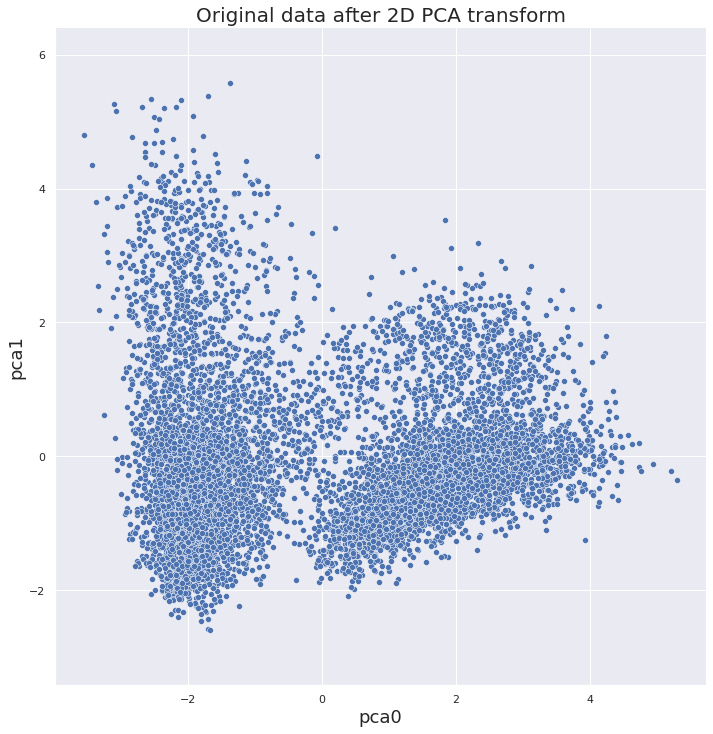

In [ ]:
title = 'Original data after 2D PCA transform'
axes_PCA_2D = {'x': 'pca0', 'y': 'pca1'}
Plot2D (samples_PCA_2D, title, axes_PCA_2D)

Ahora reducimos las dimensiones de los embeddings de 768 a 3, utilizando PCA

In [ ]:
pca3D = PCA(n_components=3)
pca3D.fit(embeddings)
samples_PCA_3D = pca3D.transform(embeddings)
df_samples_PCA_3D = pd.DataFrame(data=samples_PCA_3D, columns=["pca0", "pca1", "pca2"])
df_samples_PCA_3D

pca0      pca1      pca2
0     2.643035 -0.225375  0.339743
1    -0.569303  0.304714  1.487205
2     1.949959 -0.682822 -0.304559
3    -1.789665 -0.557673 -0.417913
4    -1.507309  0.575683  2.587773
...        ...       ...       ...
8218 -2.170985  2.261986 -0.899066
8219 -1.383888 -0.943344  0.047075
8220  2.489857 -0.055417  0.561639
8221  3.035699 -0.177738  0.056680
8222  1.177314 -1.165315 -0.339838

[8223 rows x 3 columns]

Visualización del resultado en 3 Dimensiones

In [ ]:
title = 'Original data after 3D PCA transform'
axes_PCA_3D = {'x': 'pca0', 'y': 'pca1', 'z': 'pca2'}
Plot3D (samples_PCA_3D, title, axes_PCA_3D)

Algoritmo del codo para sacar el número de clusters (Nos da 6, y el profesor dijo que tendría que darnos entre 10 y 12, pero que no ve mal este número)

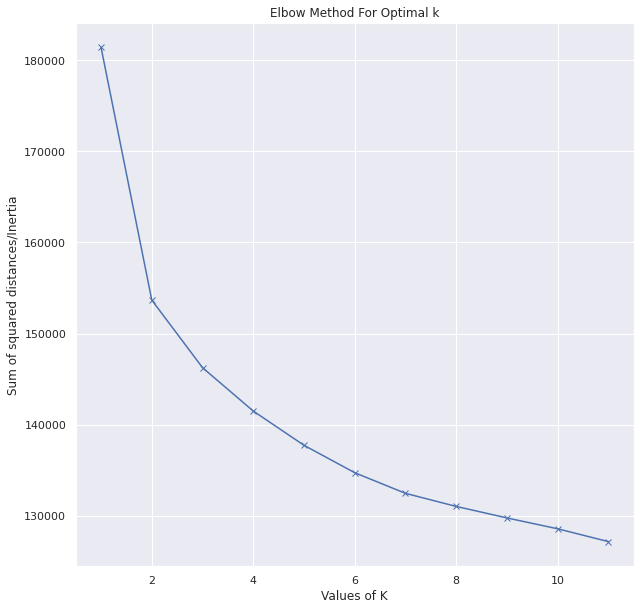

In [ ]:
Sum_of_squared_distances = []
K = range(1,12)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(embeddings)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,"bx-")
plt.xlabel("Values of K")
plt.ylabel("Sum of squared distances/Inertia")
plt.title("Elbow Method For Optimal k")
plt.show()

### Técnica de reducción de dimensionalidad alternativa: t-SNE

Probamos a reducir las dimensiones de los embeddings de 768 a 2, utilizando PCA

In [ ]:
tsne2D = TSNE(n_components=2)
samples_TSNE_2D = tsne2D.fit_transform(embeddings)
df_samples_TSNE_2D = pd.DataFrame(data=samples_TSNE_2D, columns=["tsne0", "tsne1"])
df_samples_TSNE_2D

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



tsne0      tsne1
0    -36.464630  32.421242
1     -7.781714 -13.839026
2    -58.161964  -1.294609
3      0.174356 -57.223503
4     53.683651  -8.473248
...         ...        ...
8218  38.648872  42.665855
8219  -8.876185 -27.004416
8220 -22.302328  12.571873
8221 -34.116333  20.432978
8222 -44.479107 -20.408714

[8223 rows x 2 columns]

Visualización del resultado en 2 Dimensiones

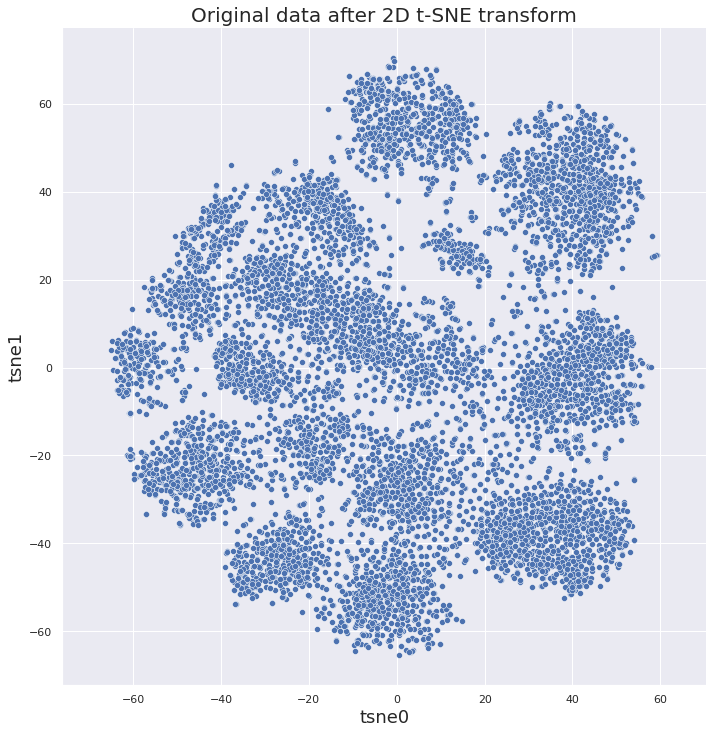

In [ ]:
title = 'Original data after 2D t-SNE transform'
axes_TSNE_2D = {'x': 'tsne0', 'y': 'tsne1'}
Plot2D (samples_TSNE_2D, title, axes_TSNE_2D)

Ahora reducimos las dimensiones de los embeddings de 768 a 3, utilizando t-SNE

In [ ]:
tsne3D = TSNE(n_components=3)
samples_TSNE_3D = tsne3D.fit_transform(embeddings)
df_samples_TSNE_3D = pd.DataFrame(data=samples_TSNE_3D, columns=["tsne0", "tsne1", "tsne2"])
df_samples_TSNE_3D

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



tsne0      tsne1      tsne2
0     18.740383  10.289138  -6.723560
1    -16.983402   2.842958 -12.626032
2      8.577450 -13.906528 -19.993334
3      0.577645 -19.615656   0.204729
4    -12.315805  -0.878154  21.451796
...         ...        ...        ...
8218  -3.443322  13.153749  24.463736
8219  -7.826160  -3.239778  -8.974807
8220  12.613815   5.377963   1.010682
8221   9.821400   7.336711 -14.327007
8222   3.308749   0.908134 -17.744591

[8223 rows x 3 columns]

Visualización del resultado en 3 Dimensiones

In [ ]:
title = 'Original data after 3D t-SNE transform'
axes_TSNE_3D = {'x': 'tsne0', 'y': 'tsne1', 'z': 'tsne2'}
Plot3D (samples_TSNE_3D, title, axes_TSNE_3D)

# Paso 6: Técnicas de clustering


##DBSCAN

### DBSCAN sobre PCA 2D (clusters: 6, sil: 0.210)

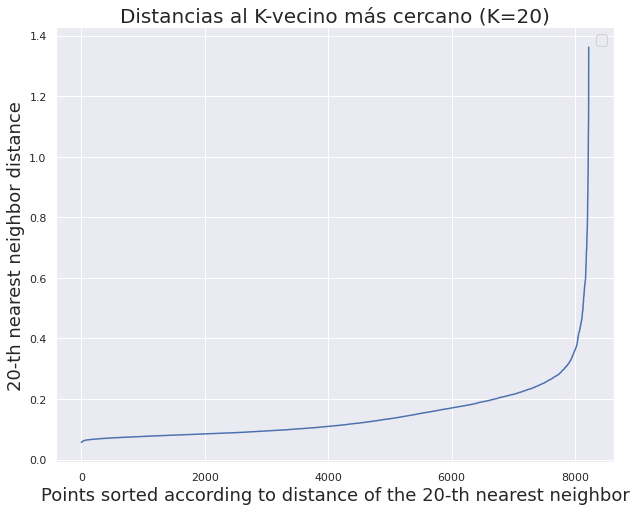

In [ ]:
PlotDistancesToKnearestNeighbor(samples_PCA_2D, 20)

In [ ]:
min_samples = 20
epsilon_values = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.75]
aux_labels = {}
for epsilon in epsilon_values:
  aux_labels[epsilon] = ApplyDBScanToData (samples_PCA_2D, epsilon, min_samples=min_samples)


Test for epsilon = 0.1
Estimated number of clusters: 6
Estimated number of noise points: 3806
Silhouette Coefficient: -0.279

Test for epsilon = 0.2
Estimated number of clusters: 6
Estimated number of noise points: 780
Silhouette Coefficient: 0.210

Test for epsilon = 0.25
Estimated number of clusters: 2
Estimated number of noise points: 302
Silhouette Coefficient: -0.100

Test for epsilon = 0.3
Estimated number of clusters: 1
Estimated number of noise points: 154
Silhouette Coefficient: 0.337

Test for epsilon = 0.4
Estimated number of clusters: 1
Estimated number of noise points: 69
Silhouette Coefficient: 0.376

Test for epsilon = 0.5
Estimated number of clusters: 1
Estimated number of noise points: 26
Silhouette Coefficient: 0.400

Test for epsilon = 0.6
Estimated number of clusters: 1
Estimated number of noise points: 10
Silhouette Coefficient: 0.434

Test for epsilon = 0.75
Estimated number of clusters: 1
Estimated number of noise points: 2
Silhouette Coefficient: 0.441


In [ ]:
epsilon = 0.2
labels_PCA_2D = aux_labels[epsilon]

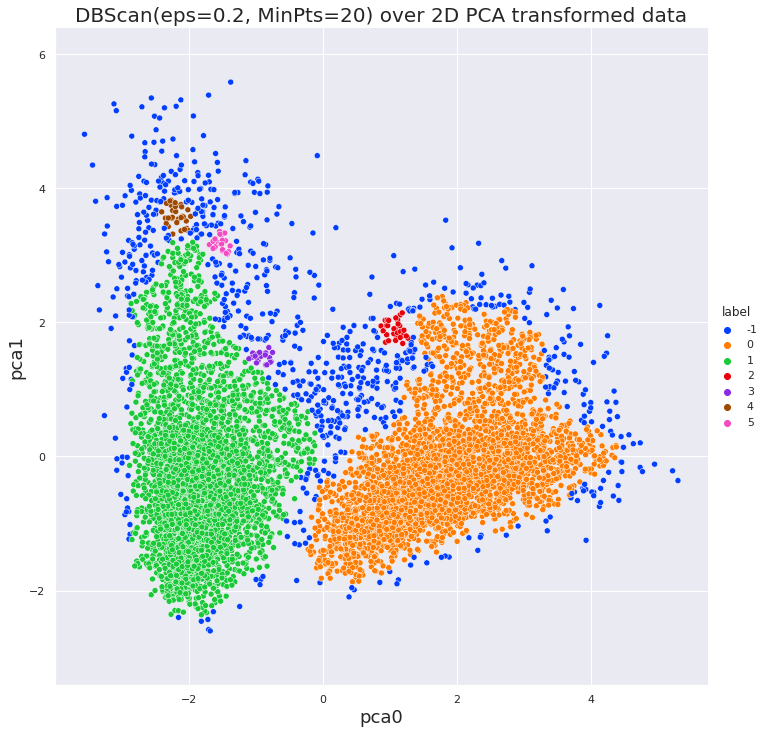

In [ ]:
title = f'DBScan(eps={epsilon}, MinPts={min_samples}) over 2D PCA transformed data'
Plot2D_WithLabels(samples_PCA_2D, labels_PCA_2D, title, axes_PCA_2D)

### DBSCAN sobre PCA 3D (clusters: 7, sil: 0.208)

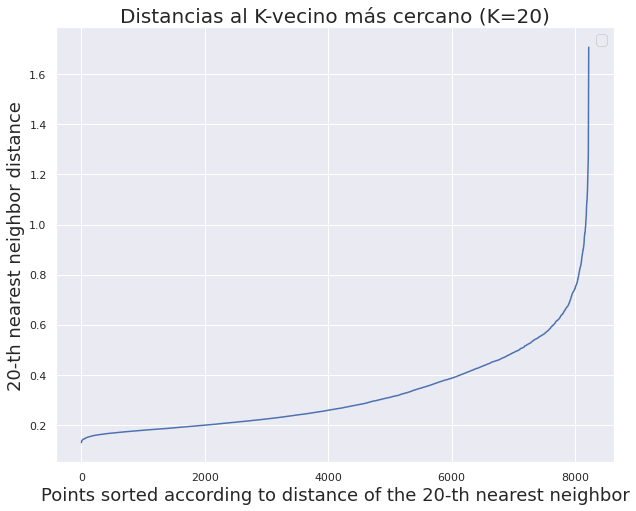

In [ ]:
PlotDistancesToKnearestNeighbor(samples_PCA_3D, 20)

In [ ]:
min_samples = 20
epsilon_values = [0.25, 0.3, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9, 1]
aux_labels = {}
for epsilon in epsilon_values:
  aux_labels[epsilon] = ApplyDBScanToData (samples_PCA_3D, epsilon, min_samples=min_samples)


Test for epsilon = 0.25
Estimated number of clusters: 3
Estimated number of noise points: 3224
Silhouette Coefficient: 0.161

Test for epsilon = 0.3
Estimated number of clusters: 5
Estimated number of noise points: 2326
Silhouette Coefficient: 0.096

Test for epsilon = 0.4
Estimated number of clusters: 7
Estimated number of noise points: 1166
Silhouette Coefficient: 0.208

Test for epsilon = 0.5
Estimated number of clusters: 1
Estimated number of noise points: 395
Silhouette Coefficient: 0.241

Test for epsilon = 0.6
Estimated number of clusters: 1
Estimated number of noise points: 142
Silhouette Coefficient: 0.264

Test for epsilon = 0.75
Estimated number of clusters: 1
Estimated number of noise points: 31
Silhouette Coefficient: 0.362

Test for epsilon = 0.8
Estimated number of clusters: 1
Estimated number of noise points: 11
Silhouette Coefficient: 0.368

Test for epsilon = 0.9
Estimated number of clusters: 1
Estimated number of noise points: 7
Silhouette Coefficient: 0.417

Test f

In [ ]:
epsilon = 0.4
labels_PCA_3D = aux_labels[epsilon]

In [ ]:
title = f'DBScan(eps={epsilon}, MinPts={min_samples}) over 3D PCA transformed data'
Plot3D_WithLabels(samples_PCA_3D, labels_PCA_3D, title, axes_PCA_3D)

### DBSCAN sobre t-SNE 2D (clusters: 15, sil: 0.390)

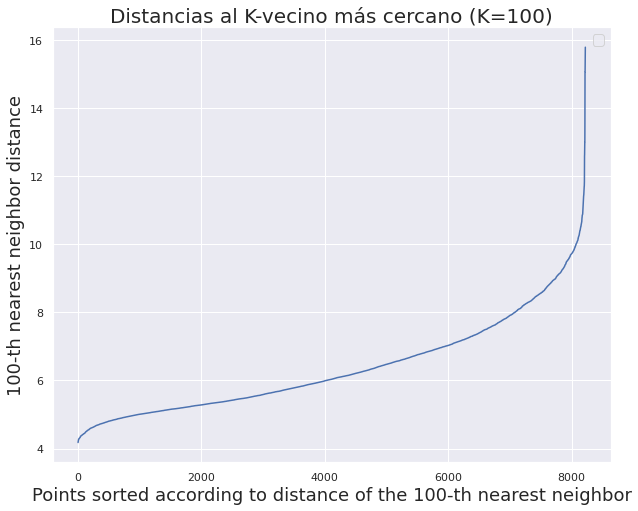

In [ ]:
PlotDistancesToKnearestNeighbor(samples_TSNE_2D, 100)

In [ ]:
min_samples = 100
epsilon_values = [4.5, 4.75, 5, 5.25, 5.5, 5.75, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75]
aux_labels = {}
for epsilon in epsilon_values:
  aux_labels[epsilon] = ApplyDBScanToData (samples_TSNE_2D, epsilon, min_samples=min_samples)


Test for epsilon = 4.5
Estimated number of clusters: 8
Estimated number of noise points: 7044
Silhouette Coefficient: -0.413

Test for epsilon = 4.75
Estimated number of clusters: 12
Estimated number of noise points: 5825
Silhouette Coefficient: -0.282

Test for epsilon = 5
Estimated number of clusters: 19
Estimated number of noise points: 3787
Silhouette Coefficient: -0.013

Test for epsilon = 5.25
Estimated number of clusters: 17
Estimated number of noise points: 2438
Silhouette Coefficient: 0.202

Test for epsilon = 5.5
Estimated number of clusters: 16
Estimated number of noise points: 1645
Silhouette Coefficient: 0.296

Test for epsilon = 5.75
Estimated number of clusters: 15
Estimated number of noise points: 1176
Silhouette Coefficient: 0.342

Test for epsilon = 6.25
Estimated number of clusters: 15
Estimated number of noise points: 488
Silhouette Coefficient: 0.390

Test for epsilon = 6.5
Estimated number of clusters: 12
Estimated number of noise points: 360
Silhouette Coefficie

In [ ]:
epsilon = 6.25
labels_TSNE_2D = aux_labels[epsilon]

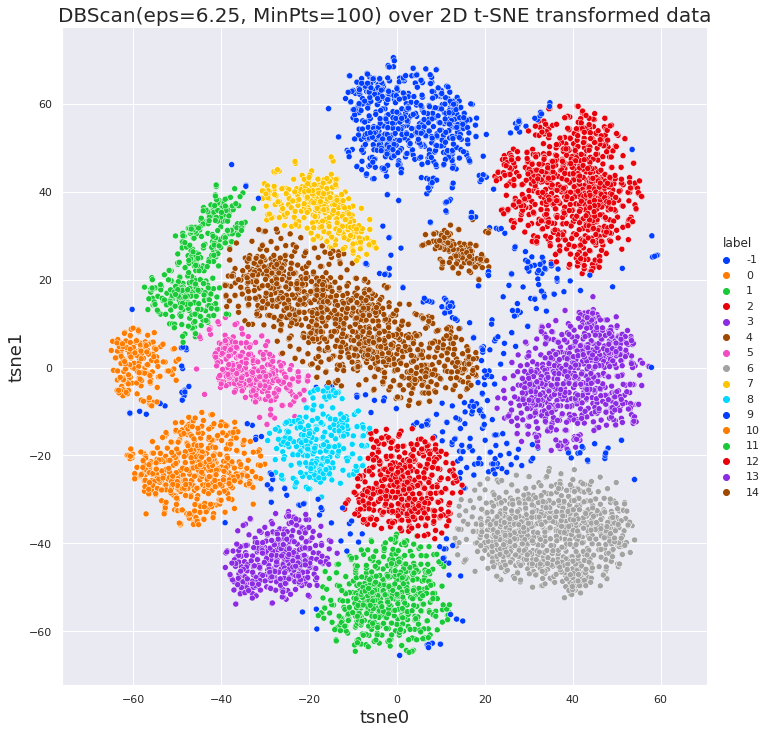

In [ ]:
title = f'DBScan(eps={epsilon}, MinPts={min_samples}) over 2D t-SNE transformed data'
Plot2D_WithLabels(samples_TSNE_2D, labels_TSNE_2D, title, axes_TSNE_2D)

### DBSCAN sobre t-SNE 3D (clusters: 12, sil: 0.269)


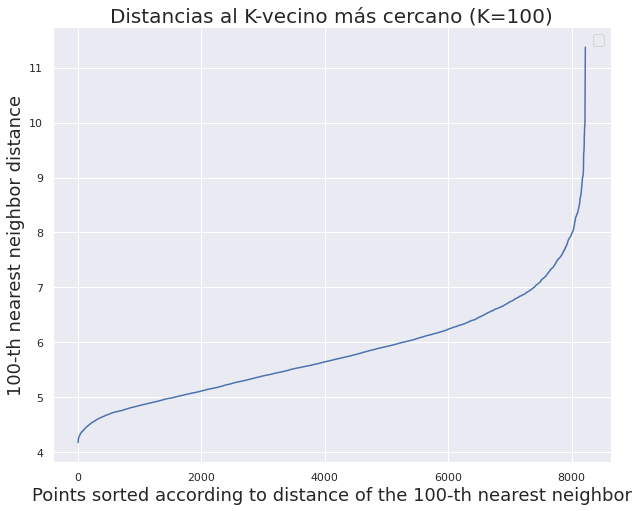

In [ ]:
PlotDistancesToKnearestNeighbor(samples_TSNE_3D, 100)

In [ ]:
min_samples = 100
epsilon_values = [4.5, 4.75, 5, 5.25, 5.5, 5.75, 6.25, 6.5, 6.75, 7, 7.25]
aux_labels = {}
for epsilon in epsilon_values:
  aux_labels[epsilon] = ApplyDBScanToData (samples_TSNE_3D, epsilon, min_samples=min_samples)


Test for epsilon = 4.5
Estimated number of clusters: 9
Estimated number of noise points: 6013
Silhouette Coefficient: -0.226

Test for epsilon = 4.75
Estimated number of clusters: 16
Estimated number of noise points: 2965
Silhouette Coefficient: 0.079

Test for epsilon = 5
Estimated number of clusters: 12
Estimated number of noise points: 1423
Silhouette Coefficient: 0.220

Test for epsilon = 5.25
Estimated number of clusters: 12
Estimated number of noise points: 716
Silhouette Coefficient: 0.269

Test for epsilon = 5.5
Estimated number of clusters: 6
Estimated number of noise points: 338
Silhouette Coefficient: 0.026

Test for epsilon = 5.75
Estimated number of clusters: 2
Estimated number of noise points: 159
Silhouette Coefficient: -0.107

Test for epsilon = 6.25
Estimated number of clusters: 1
Estimated number of noise points: 36
Silhouette Coefficient: 0.019

Test for epsilon = 6.5
Estimated number of clusters: 1
Estimated number of noise points: 18
Silhouette Coefficient: -0.008

In [ ]:
epsilon = 5.25
labels_TSNE_3D = aux_labels[epsilon]

In [ ]:
title = f'DBScan(eps={epsilon}, MinPts={min_samples}) over 3D t-SNE transformed data'
Plot3D_WithLabels (samples_TSNE_3D, labels_TSNE_3D, title, axes_TSNE_3D)

## K-Means

### K-Means sobre PCA 2D (clusters: 10, sil: 0.350/0.400)

Buscamos un valor K para el número de clusters objetivo que resulte más adecuado para nuestros datos transformados vía PCA a 2 dimensiones

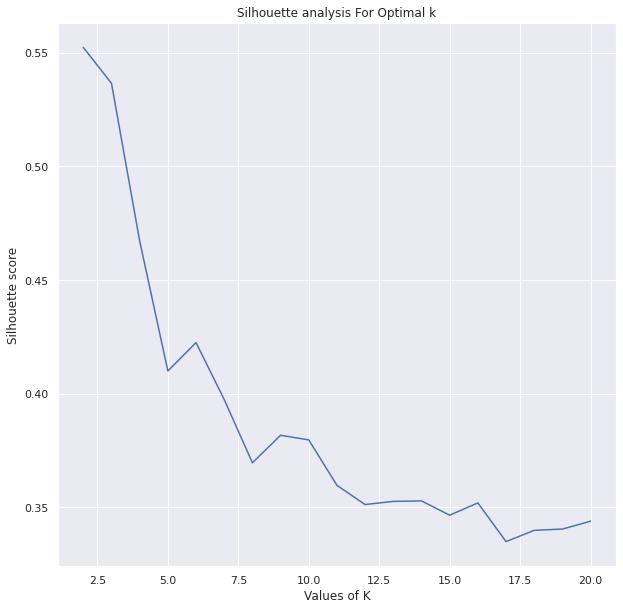

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_avg = []
for num_clusters in range_n_clusters:
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(samples_PCA_2D)
 cluster_labels = kmeans.labels_
 # silhouette score
 silhouette_avg.append(silhouette_score(samples_PCA_2D, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [ ]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(samples_PCA_2D)
labels_kmeans_PCA_2D = kmeans.labels_
labels_kmeans_PCA_2D

array([8, 5, 2, ..., 2, 8, 0], dtype=int32)

In [ ]:
centroids_kmeans_PCA_2D = kmeans.cluster_centers_
centroids_kmeans_PCA_2D

array([[ 0.7841808 , -0.9188557 ],
       [-2.0980065 , -0.21331954],
       [ 1.8909408 , -0.29993436],
       [-2.0141141 ,  3.373484  ],
       [ 0.5965504 ,  1.2178218 ],
       [-1.0676893 , -0.05571533],
       [-1.955759  ,  1.4506402 ],
       [-1.8920878 , -1.3485432 ],
       [ 3.1910658 ,  0.01673991],
       [ 2.376606  ,  1.571541  ]], dtype=float32)

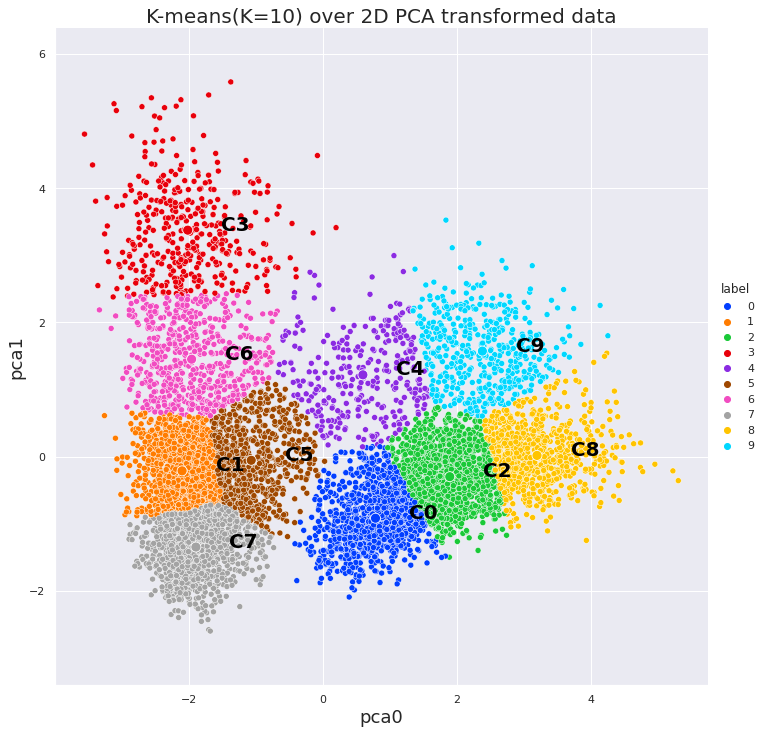

In [ ]:
title = f'K-means(K={n_clusters}) over 2D PCA transformed data'
plot = Plot2D_WithLabels (samples_PCA_2D, labels_kmeans_PCA_2D, title, axes_PCA_2D, centroids_2D=centroids_kmeans_PCA_2D)

### K-Means sobre PCA 3D (clusters: 10, sil: 0.320/0.350)

Buscamos un valor K para el número de clusters objetivo que resulte más adecuado para nuestros datos transformados vía PCA a 3 dimensiones

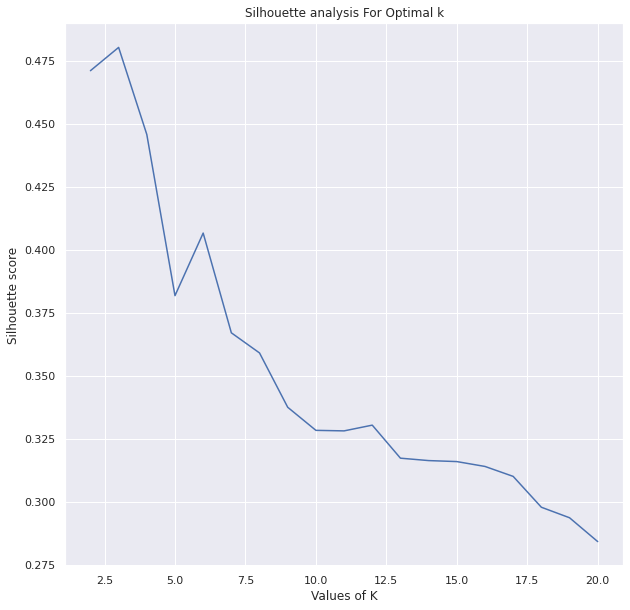

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_avg = []
for num_clusters in range_n_clusters:
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(samples_PCA_3D)
 cluster_labels = kmeans.labels_
 # silhouette score
 silhouette_avg.append(silhouette_score(samples_PCA_3D, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [ ]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(samples_PCA_3D)
labels_kmeans_PCA_3D = kmeans.labels_
labels_kmeans_PCA_3D

array([8, 6, 3, ..., 8, 8, 1], dtype=int32)

In [ ]:
centroids_kmeans_PCA_3D = kmeans.cluster_centers_
centroids_kmeans_PCA_3D

array([[-1.9489795 ,  0.25600642,  1.8343654 ],
       [ 0.8955277 , -0.9675648 , -0.62249833],
       [-1.9201022 , -1.4336251 , -0.90076715],
       [ 1.7601448 , -0.16914469,  0.33891484],
       [ 1.9725914 ,  1.6372567 , -0.9829276 ],
       [-2.016805  ,  3.437731  , -1.1668199 ],
       [-0.5494864 ,  0.6856011 ,  1.4794401 ],
       [-2.0524726 ,  1.5399126 , -0.99591345],
       [ 3.10944   ,  0.04841526,  0.27353218],
       [-1.7412015 , -0.54774964,  0.35675392]], dtype=float32)

In [ ]:
title = f'K-means(K={n_clusters}) over 3D PCA transformed data'
plot = Plot3D_WithLabels (samples_PCA_3D, labels_kmeans_PCA_3D, title, axes_PCA_3D, centroids_3D=centroids_kmeans_PCA_3D)

<ipython-input-4-9ca9fcc398ff>:353: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### K-Means sobre t-SNE 2D (clusters: 12, sil: 0.440) (Muy Buen Resultado)



Buscamos un valor K para el número de clusters objetivo que resulte más adecuado para nuestros datos transformados vía t-SNE a 2 dimensiones

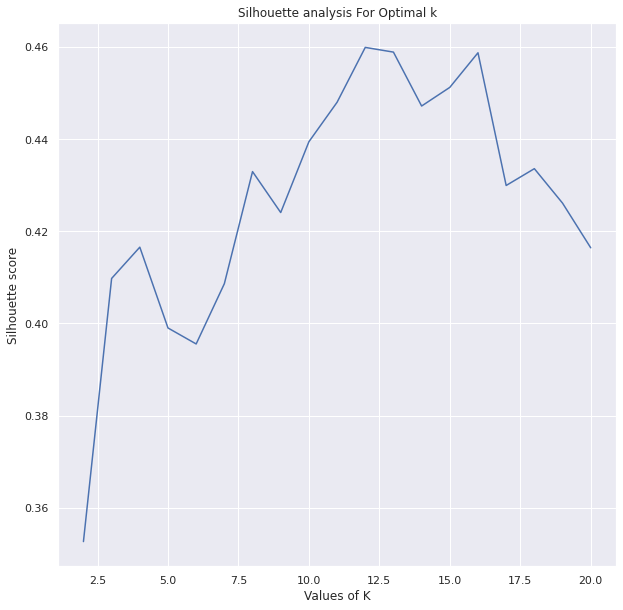

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_avg = []
for num_clusters in range_n_clusters:
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(samples_TSNE_2D)
 cluster_labels = kmeans.labels_
 # silhouette score
 silhouette_avg.append(silhouette_score(samples_TSNE_2D, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [ ]:
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(samples_TSNE_2D)
labels_kmeans_TSNE_2D = kmeans.labels_
labels_kmeans_TSNE_2D

array([10, 11,  6, ..., 10, 10,  3], dtype=int32)

In [ ]:
centroids_kmeans_TSNE_2D = kmeans.cluster_centers_
centroids_kmeans_TSNE_2D

array([[ -1.5446799, -52.19118  ],
       [  4.341698 ,   9.592754 ],
       [ 40.16233  ,  -2.184791 ],
       [-46.551136 , -22.50818  ],
       [  3.697429 , -25.422487 ],
       [ 38.936947 ,  40.25462  ],
       [-48.399044 ,  10.692602 ],
       [ 35.379677 , -37.756096 ],
       [  2.4958682,  55.468254 ],
       [-26.525167 , -42.929596 ],
       [-23.644243 ,  28.194633 ],
       [-21.520725 ,  -7.098209 ]], dtype=float32)

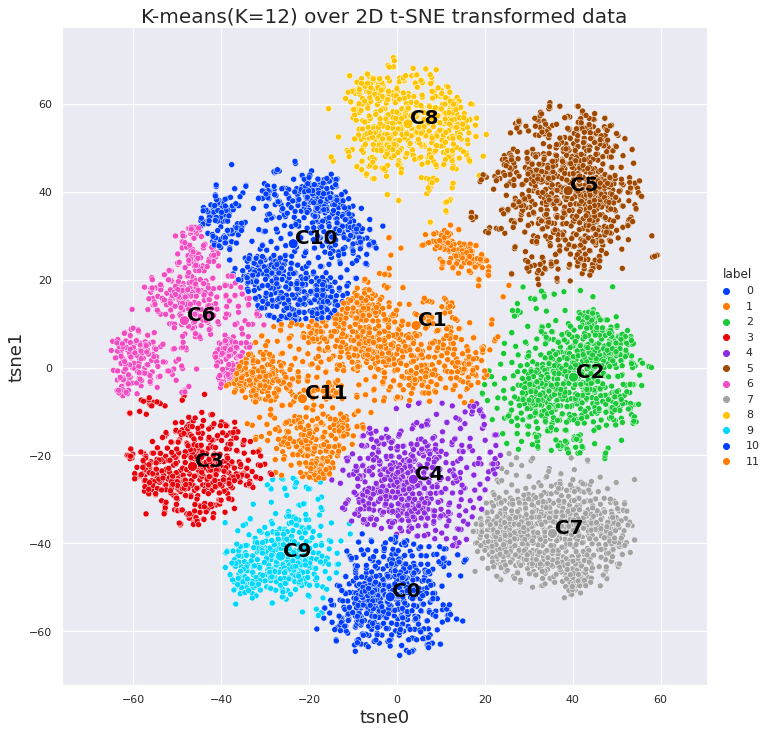

In [ ]:
title = f'K-means(K={n_clusters}) over 2D t-SNE transformed data'
plot = Plot2D_WithLabels (samples_TSNE_2D, labels_kmeans_TSNE_2D, title, axes_TSNE_2D, centroids_2D=centroids_kmeans_TSNE_2D)

### K-Means sobre t-SNE 3D (clusters: 12, sil: 0.350) (Buen Resultado)

Buscamos un valor K para el número de clusters objetivo que resulte más adecuado para nuestros datos transformados vía t-SNE a 3 dimensiones

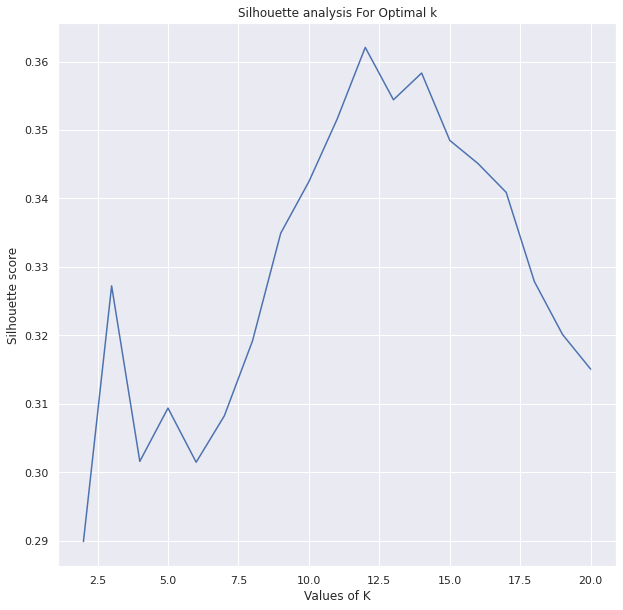

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_avg = []
for num_clusters in range_n_clusters:
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(samples_TSNE_3D)
 cluster_labels = kmeans.labels_
 # silhouette score
 silhouette_avg.append(silhouette_score(samples_TSNE_3D, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [ ]:
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(samples_TSNE_3D)
labels_kmeans_TSNE_3D = kmeans.labels_
labels_kmeans_TSNE_3D

array([2, 0, 4, ..., 2, 2, 6], dtype=int32)

In [ ]:
centroids_kmeans_TSNE_3D = kmeans.cluster_centers_
centroids_kmeans_TSNE_3D

array([[-14.0228    ,  -3.7322671 ,  -8.51818   ],
       [  2.6588845 ,  -0.89441323,   1.415555  ],
       [ 15.286019  ,   5.5604677 ,  -8.978957  ],
       [-23.960526  ,  -9.899188  ,   5.5574417 ],
       [  4.325152  , -13.962936  , -17.778166  ],
       [ 14.419633  ,  13.976881  ,   8.504773  ],
       [  1.6053901 ,   1.8029836 , -20.066746  ],
       [ -0.07441759,  12.648458  ,  21.858961  ],
       [ -4.6716385 , -19.26872   ,  -2.6994474 ],
       [-11.567899  ,   1.3552063 ,  11.448608  ],
       [ -0.5868722 ,  18.075962  ,  -2.278429  ],
       [ 18.173555  ,  -7.0042386 ,  -1.706008  ]], dtype=float32)

In [ ]:
title = f'K-means(K={n_clusters}) over 3D t-SNE transformed data'
plot = Plot3D_WithLabels (samples_TSNE_3D, labels_kmeans_TSNE_3D, title, axes_TSNE_3D, centroids_3D=centroids_kmeans_TSNE_3D)

<ipython-input-4-9ca9fcc398ff>:353: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



## EM

### EM sobre PCA 2D (clusters: 10, sil: 0.350/0.400)

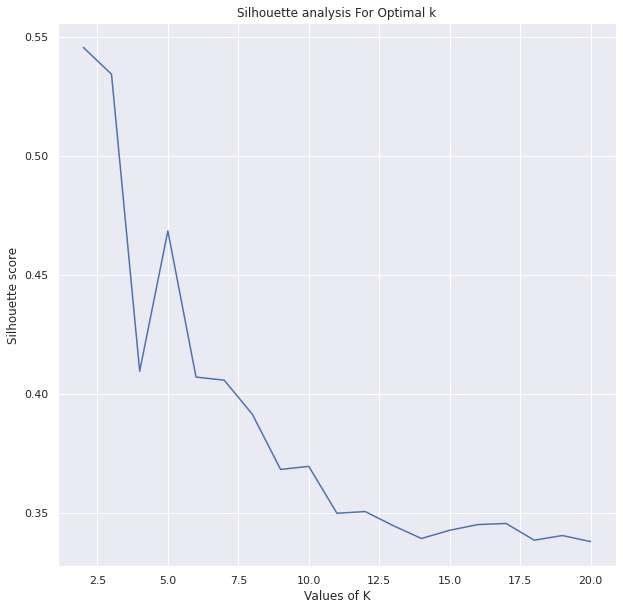

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_avg = []
for num_clusters in range_n_clusters:
 # initialise kmeans
 gm_2D = GaussianMixture(n_components=num_clusters, random_state=0)
 gm_2D.fit(samples_PCA_2D)
 cluster_labels = gm_2D.predict(samples_PCA_2D)
 # silhouette score
 silhouette_avg.append(silhouette_score(samples_PCA_2D, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [ ]:
n_clusters = 10
gm_2D = GaussianMixture(n_components=n_clusters, random_state=0).fit(samples_PCA_2D)
labels_EM_PCA_2D = gm_2D.predict(samples_PCA_2D)
labels_EM_PCA_2D

array([3, 9, 1, ..., 3, 3, 8])

In [ ]:
centroids_EM_PCA_2D = gm_2D.means_
centroids_EM_PCA_2D

array([[-1.35253488e+00, -5.38567918e-01],
       [ 1.81433355e+00, -3.41682162e-01],
       [-2.13021948e+00,  1.65922280e+00],
       [ 3.00352870e+00, -2.14890995e-02],
       [ 2.14717543e+00,  1.48464759e+00],
       [-2.01049762e+00, -1.24549188e+00],
       [-1.91032838e+00,  3.34735443e+00],
       [-2.02269912e+00, -2.37664395e-03],
       [ 8.33731041e-01, -9.38870270e-01],
       [-4.73491675e-01,  6.91154297e-01]])

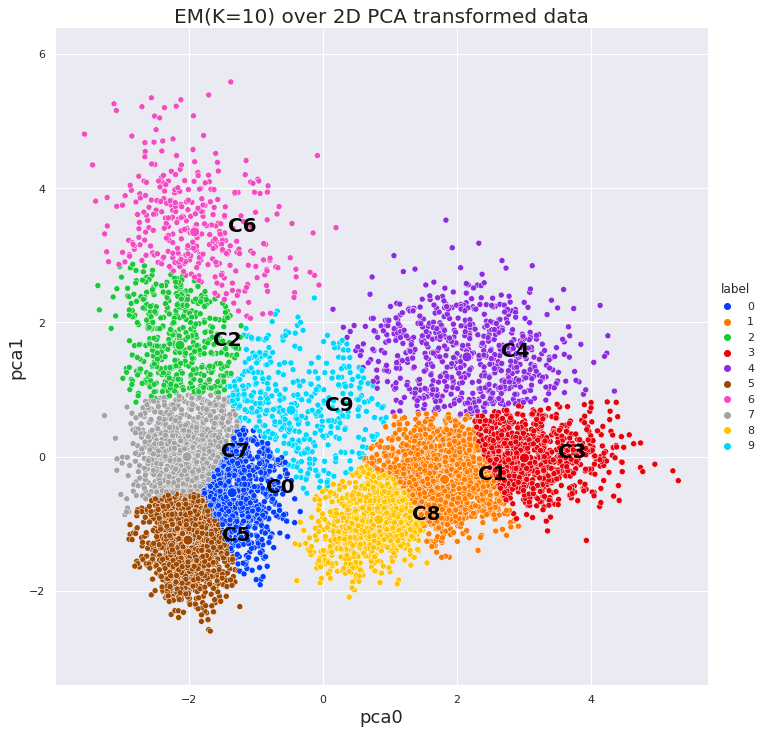

In [ ]:
title = f'EM(K={n_clusters}) over 2D PCA transformed data'
plot = Plot2D_WithLabels (samples_PCA_2D, labels_EM_PCA_2D, title, axes_PCA_2D, centroids_2D=centroids_EM_PCA_2D)

### EM sobre PCA 3D (clusters: 10, sil: 0.250/0.300)

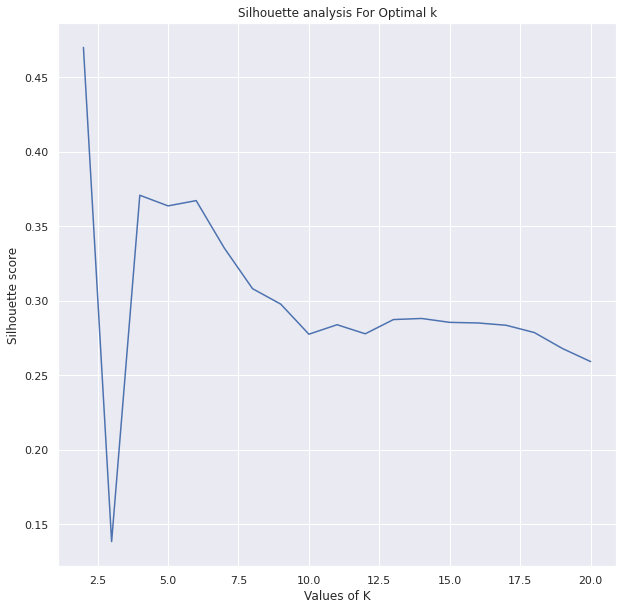

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_avg = []
for num_clusters in range_n_clusters:
 # initialise kmeans
 gm_3D = GaussianMixture(n_components=num_clusters, random_state=0)
 gm_3D.fit(samples_PCA_3D)
 cluster_labels = gm_3D.predict(samples_PCA_3D)
 # silhouette score
 silhouette_avg.append(silhouette_score(samples_PCA_3D, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [ ]:
n_clusters = 10
gm_3D = GaussianMixture(n_components=n_clusters, random_state=0).fit(samples_PCA_3D)
labels_EM_PCA_3D = gm_3D.predict(samples_PCA_3D)
labels_EM_PCA_3D

array([3, 6, 1, ..., 3, 3, 1])

In [ ]:
centroids_EM_PCA_3D = gm_3D.means_
centroids_EM_PCA_3D

array([[-1.67232375, -0.25046668,  0.99509797],
       [ 1.15449801, -0.88604723, -0.48008869],
       [-1.80468192,  3.15903272, -0.82221685],
       [ 2.8908041 , -0.14771975,  0.15438415],
       [-2.02939617, -1.52885193, -0.98419235],
       [ 2.00928472,  1.4337419 , -0.82461361],
       [-1.19860682,  0.49872792,  1.94541274],
       [ 1.70425759, -0.09637948,  0.47921488],
       [-2.05675417,  1.36278641, -0.70797848],
       [-1.80887493, -0.84462872, -0.06869683]])

In [ ]:
title = f'EM(K={n_clusters}) over 3D PCA transformed data'
plot = Plot3D_WithLabels (samples_PCA_3D, labels_EM_PCA_3D, title, axes_PCA_3D, centroids_3D=centroids_EM_PCA_3D)

<ipython-input-4-9ca9fcc398ff>:353: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### EM sobre t-SNE 2D (clusters: 11, sil: 0.420/0.440)

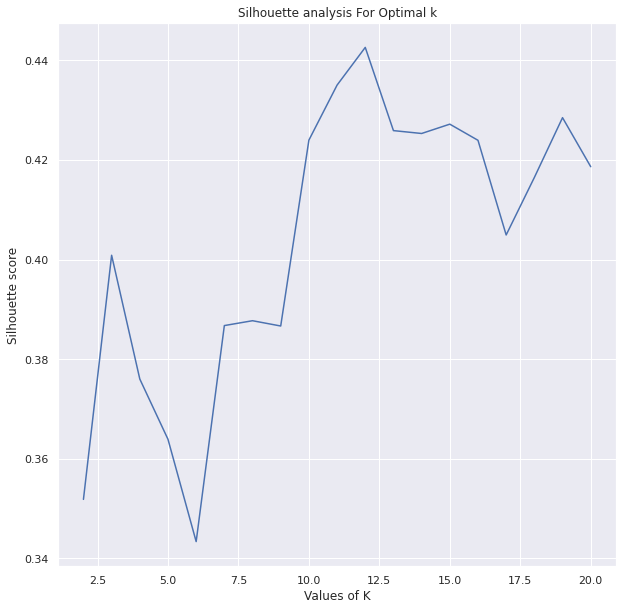

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_avg = []
for num_clusters in range_n_clusters:
 # initialise kmeans
 gm_2D = GaussianMixture(n_components=num_clusters, random_state=0)
 gm_2D.fit(samples_TSNE_2D)
 cluster_labels = gm_2D.predict(samples_TSNE_2D)
 # silhouette score
 silhouette_avg.append(silhouette_score(samples_TSNE_2D, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [ ]:
n_clusters = 11
gm_2D = GaussianMixture(n_components=n_clusters, random_state=0).fit(samples_TSNE_2D)
labels_EM_TSNE_2D = gm_2D.predict(samples_TSNE_2D)
labels_EM_TSNE_2D

array([ 6,  1, 10, ...,  1,  6, 10])

In [ ]:
centroids_EM_TSNE_2D = gm_2D.means_
centroids_EM_TSNE_2D

array([[  2.63721857, -27.14351111],
       [ -0.33077567,   8.40947761],
       [ 39.20393166,  40.30516651],
       [-26.80508604, -44.38585192],
       [  3.00196778,  56.30616232],
       [ 40.29441562,  -3.15766954],
       [-31.26333007,  25.37187308],
       [-26.05309181,  -9.30444529],
       [ -2.2577984 , -52.75791331],
       [ 34.75171301, -37.97141982],
       [-48.80155894, -19.43915753]])

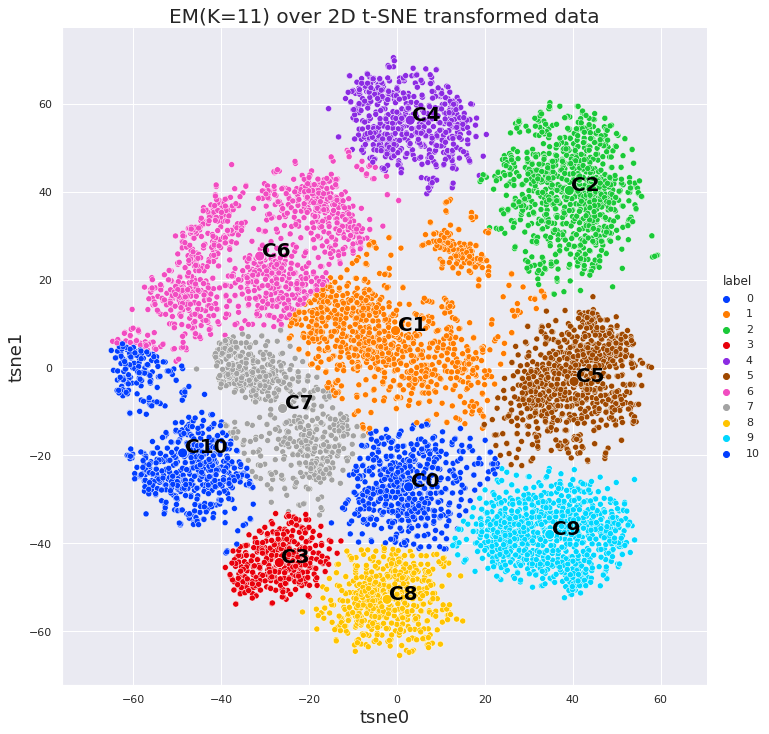

In [ ]:
title = f'EM(K={n_clusters}) over 2D t-SNE transformed data'
plot = Plot2D_WithLabels (samples_TSNE_2D, labels_EM_TSNE_2D, title, axes_TSNE_2D, centroids_2D=centroids_EM_TSNE_2D)

### EM sobre t-SNE 3D (clusters: 12, sil: 0.340)

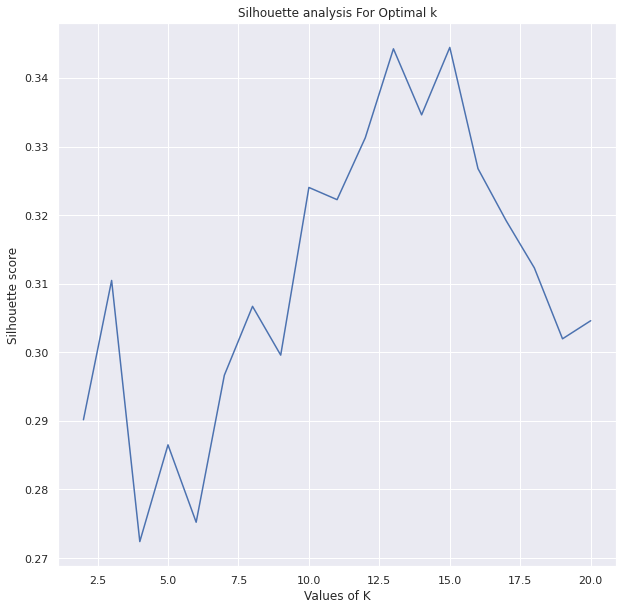

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_avg = []
for num_clusters in range_n_clusters:
 # initialise kmeans
 gm_3D = GaussianMixture(n_components=num_clusters, random_state=0)
 gm_3D.fit(samples_TSNE_3D)
 cluster_labels = gm_3D.predict(samples_TSNE_3D)
 # silhouette score
 silhouette_avg.append(silhouette_score(samples_TSNE_3D, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [ ]:
n_clusters = 12
gm_3D = GaussianMixture(n_components=n_clusters, random_state=0).fit(samples_TSNE_3D)
labels_EM_TSNE_3D = gm_3D.predict(samples_TSNE_3D)
labels_EM_TSNE_3D

array([8, 0, 7, ..., 4, 8, 2])

In [ ]:
centroids_EM_TSNE_3D = gm_3D.means_
centroids_EM_TSNE_3D

array([[-14.16366651,  -3.91298422,  -8.50882261],
       [ 13.82880725,  14.27967286,   8.78760915],
       [  1.54698298,   1.71627577, -20.55092593],
       [ -5.03703657,  -2.64382246,   9.06187957],
       [ 13.2287689 ,  -5.32434235,  -2.24928776],
       [ -0.13770005,  12.31363237,  22.22328035],
       [  2.30164807,  12.45366685,  -4.94178199],
       [  3.36707113, -14.98648561, -18.09259534],
       [ 16.70099182,   4.59660968,  -9.70092573],
       [-23.52465034, -10.32653337,   5.09894913],
       [-11.62208219,   9.09949118,   8.90034369],
       [ -4.58483701, -19.71657492,  -2.22205069]])

In [ ]:
title = f'EM(K={n_clusters}) over 3D t-SNE transformed data'
plot = Plot3D_WithLabels (samples_TSNE_3D, labels_EM_TSNE_3D, title, axes_TSNE_3D, centroids_3D=centroids_EM_TSNE_3D)

<ipython-input-4-9ca9fcc398ff>:353: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# Paso 7: Interpretación de los clusters

Para realizar nuestro análisis sobre los resultados obtenidos con las diferentes estrategias de clustering que hemos realizado anteriormente, asignamos a la variable **labels** la variable que contenga el array con la lista de etiquetas o ids de los clusters resultantes para la estrategia en cuyo análisis estemos interesados.

Primero lo haremos con los embeddings de K-Means TSNE_3D

In [ ]:
labels = labels_kmeans_TSNE_3D

In [ ]:
(unique, counts) = np.unique(labels, return_counts=True)

print('Esta es la distribución de muestras disponibles para cada cluster')
for i in range(len(unique)):
  print('[cluster = %s][%d samples]' % (unique[i], counts[i]))
print('----------------------------')
print('[TODAS][%d samples]\n' % (len(labels)))

Esta es la distribución de muestras disponibles para cada cluster
[cluster = 0][557 samples]
[cluster = 1][697 samples]
[cluster = 2][730 samples]
[cluster = 3][838 samples]
[cluster = 4][640 samples]
[cluster = 5][676 samples]
[cluster = 6][571 samples]
[cluster = 7][897 samples]
[cluster = 8][620 samples]
[cluster = 9][826 samples]
[cluster = 10][588 samples]
[cluster = 11][583 samples]
----------------------------
[TODAS][8223 samples]



Recuperamos el conjunto de ids únicos que identifican a nuestros clusters y componemos una lista de claves a partir de la cual crearemos el diccionario

In [ ]:
values_labels, k = np.unique(labels, return_counts=True)
label_key_list = list(map(str, values_labels))
label_key_list

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']

Recordemos que **"df_tweets"** es un dataframe en el que cada fila corresponde a un tweet diferente

In [ ]:
df_tweets

0
0     0\tLa Gran Guerra de #JuegoDeTronos nos ha dej...
1     1\tEl golpe de Estado en #Venezuela está más l...
2     2\tNo tengo una foto en la catedral de #NotreD...
3     3\t#NotreDame nunca llegue a visitar tan grand...
4      4\tA tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos
...                                                 ...
8218  8218\t#ChampionsLeague 83’ Gooooooool de Messi...
8219  8219\tLlegarán más venezolanos y la crisis hum...
8220  8220\tHoy estamos de fiesta y deberías visitar...
8221  8221\tMenos 📲 y más 📚. "El libro es el arma má...
8222  8222\tEl emocionado discurso de la activista e...

[8223 rows x 1 columns]

Vamos a añadir a dicho dataframe una nueva columna con la información de la etiqueta correspondiente al cluster al que dicha medida ha sido asignada como resultado del clustering:

In [ ]:
n_nodes = 1
labels_per_node = np.repeat(labels, n_nodes)

In [ ]:
len(labels_per_node)

8223

In [ ]:
df_tweets_clustered = df_tweets.copy()            # We create a copy of the original dataframe
df_tweets_clustered["cluster"] = labels_per_node # We add a new column with the corresponding cluster info for each sample
df_tweets_clustered

0  cluster
0     0\tLa Gran Guerra de #JuegoDeTronos nos ha dej...        2
1     1\tEl golpe de Estado en #Venezuela está más l...        0
2     2\tNo tengo una foto en la catedral de #NotreD...        4
3     3\t#NotreDame nunca llegue a visitar tan grand...        8
4      4\tA tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos        9
...                                                 ...      ...
8218  8218\t#ChampionsLeague 83’ Gooooooool de Messi...        7
8219  8219\tLlegarán más venezolanos y la crisis hum...        0
8220  8220\tHoy estamos de fiesta y deberías visitar...        2
8221  8221\tMenos 📲 y más 📚. "El libro es el arma má...        2
8222  8222\tEl emocionado discurso de la activista e...        6

[8223 rows x 2 columns]

In [ ]:
# Transformamos todos los dataframes de pandas en arrays de numpy para poder realizar operaciones sobre los datos

tweets_cluster_0 = (df_tweets_clustered.loc[df_tweets_clustered['cluster'] == 0]).drop('cluster', axis = 1).to_numpy()
tweets_cluster_1 = (df_tweets_clustered.loc[df_tweets_clustered['cluster'] == 1]).drop('cluster', axis = 1).to_numpy()
tweets_cluster_2 = (df_tweets_clustered.loc[df_tweets_clustered['cluster'] == 2]).drop('cluster', axis = 1).to_numpy()
tweets_cluster_3 = (df_tweets_clustered.loc[df_tweets_clustered['cluster'] == 3]).drop('cluster', axis = 1).to_numpy()
tweets_cluster_4 = (df_tweets_clustered.loc[df_tweets_clustered['cluster'] == 4]).drop('cluster', axis = 1).to_numpy()
tweets_cluster_5 = (df_tweets_clustered.loc[df_tweets_clustered['cluster'] == 5]).drop('cluster', axis = 1).to_numpy()
tweets_cluster_6 = (df_tweets_clustered.loc[df_tweets_clustered['cluster'] == 6]).drop('cluster', axis = 1).to_numpy()
tweets_cluster_7 = (df_tweets_clustered.loc[df_tweets_clustered['cluster'] == 7]).drop('cluster', axis = 1).to_numpy()
tweets_cluster_8 = (df_tweets_clustered.loc[df_tweets_clustered['cluster'] == 8]).drop('cluster', axis = 1).to_numpy()
tweets_cluster_9 = (df_tweets_clustered.loc[df_tweets_clustered['cluster'] == 9]).drop('cluster', axis = 1).to_numpy()
tweets_cluster_10 = (df_tweets_clustered.loc[df_tweets_clustered['cluster'] == 10]).drop('cluster', axis = 1).to_numpy()
tweets_cluster_11 = (df_tweets_clustered.loc[df_tweets_clustered['cluster'] == 11]).drop('cluster', axis = 1).to_numpy()
tweets_cluster_0[0]


array(['1\tEl golpe de Estado en #Venezuela está más lejos que el final de Elif. #VenezuelaEnBatallaYVictoria #VenezuelaNoSeRinde #VenezuelaHoy'],
      dtype=object)

## Clusters

In [ ]:
# Creamos una lista vacía en la que irán todas las palabras del cluster 0.

words_in_cluster_0 = []
words_in_cluster_1 = []
words_in_cluster_2 = []
words_in_cluster_3 = []
words_in_cluster_4 = []
words_in_cluster_5 = []
words_in_cluster_6 = []
words_in_cluster_7 = []
words_in_cluster_8 = []
words_in_cluster_9 = []
words_in_cluster_10 = []
words_in_cluster_11 = []

In [ ]:
# Creamos un array numpy vacío en el que vamos a añadir todos los elementos de tipo objeto ( o sea, cada tweet individual) de nuestro conjunto de datos relativos al cluster 0

words_in_cluster_0_array = np.array([])
for x in range(tweets_cluster_0.size):
  words_in_cluster_0_array = np.union1d(words_in_cluster_0_array, tweets_cluster_0[x])
len(words_in_cluster_0_array)

# Creamos un array numpy vacío en el que vamos a añadir todos los elementos de tipo objeto ( o sea, cada tweet individual) de nuestro conjunto de datos relativos al cluster 1

words_in_cluster_1_array = np.array([])
for x in range(tweets_cluster_1.size):
  words_in_cluster_1_array = np.union1d(words_in_cluster_1_array, tweets_cluster_1[x])
len(words_in_cluster_1_array)

# Creamos un array numpy vacío en el que vamos a añadir todos los elementos de tipo objeto ( o sea, cada tweet individual) de nuestro conjunto de datos relativos al cluster 2

words_in_cluster_2_array = np.array([])
for x in range(tweets_cluster_2.size):
  words_in_cluster_2_array = np.union1d(words_in_cluster_2_array, tweets_cluster_2[x])
len(words_in_cluster_2_array)

# Creamos un array numpy vacío en el que vamos a añadir todos los elementos de tipo objeto ( o sea, cada tweet individual) de nuestro conjunto de datos relativos al cluster 3

words_in_cluster_3_array = np.array([])
for x in range(tweets_cluster_3.size):
  words_in_cluster_3_array = np.union1d(words_in_cluster_3_array, tweets_cluster_3[x])
len(words_in_cluster_3_array)

# Creamos un array numpy vacío en el que vamos a añadir todos los elementos de tipo objeto ( o sea, cada tweet individual) de nuestro conjunto de datos relativos al cluster 4

words_in_cluster_4_array = np.array([])
for x in range(tweets_cluster_4.size):
  words_in_cluster_4_array = np.union1d(words_in_cluster_4_array, tweets_cluster_4[x])
len(words_in_cluster_4_array)

# Creamos un array numpy vacío en el que vamos a añadir todos los elementos de tipo objeto ( o sea, cada tweet individual) de nuestro conjunto de datos relativos al cluster 5

words_in_cluster_5_array = np.array([])
for x in range(tweets_cluster_5.size):
  words_in_cluster_5_array = np.union1d(words_in_cluster_5_array, tweets_cluster_5[x])
len(words_in_cluster_5_array)

# Creamos un array numpy vacío en el que vamos a añadir todos los elementos de tipo objeto ( o sea, cada tweet individual) de nuestro conjunto de datos relativos al cluster 6

words_in_cluster_6_array = np.array([])
for x in range(tweets_cluster_6.size):
  words_in_cluster_6_array = np.union1d(words_in_cluster_6_array, tweets_cluster_6[x])
len(words_in_cluster_6_array)

# Creamos un array numpy vacío en el que vamos a añadir todos los elementos de tipo objeto ( o sea, cada tweet individual) de nuestro conjunto de datos relativos al cluster 7

words_in_cluster_7_array = np.array([])
for x in range(tweets_cluster_7.size):
  words_in_cluster_7_array = np.union1d(words_in_cluster_7_array, tweets_cluster_7[x])
len(words_in_cluster_7_array)

# Creamos un array numpy vacío en el que vamos a añadir todos los elementos de tipo objeto ( o sea, cada tweet individual) de nuestro conjunto de datos relativos al cluster 8

words_in_cluster_8_array = np.array([])
for x in range(tweets_cluster_8.size):
  words_in_cluster_8_array = np.union1d(words_in_cluster_8_array, tweets_cluster_8[x])
len(words_in_cluster_8_array)

# Creamos un array numpy vacío en el que vamos a añadir todos los elementos de tipo objeto ( o sea, cada tweet individual) de nuestro conjunto de datos relativos al cluster 9

words_in_cluster_9_array = np.array([])
for x in range(tweets_cluster_9.size):
  words_in_cluster_9_array = np.union1d(words_in_cluster_9_array, tweets_cluster_9[x])
len(words_in_cluster_9_array)

# Creamos un array numpy vacío en el que vamos a añadir todos los elementos de tipo objeto ( o sea, cada tweet individual) de nuestro conjunto de datos relativos al cluster 10

words_in_cluster_10_array = np.array([])
for x in range(tweets_cluster_10.size):
  words_in_cluster_10_array = np.union1d(words_in_cluster_10_array, tweets_cluster_10[x])
len(words_in_cluster_10_array)

# Creamos un array numpy vacío en el que vamos a añadir todos los elementos de tipo objeto ( o sea, cada tweet individual) de nuestro conjunto de datos relativos al cluster 11

words_in_cluster_11_array = np.array([])
for x in range(tweets_cluster_11.size):
  words_in_cluster_11_array = np.union1d(words_in_cluster_11_array, tweets_cluster_11[x])
len(words_in_cluster_11_array)

583

In [ ]:
# Atención: ejecutar sólo una vez!!
# Aquí añadimos a la lista vacía words_in_cluster_0 creada anteriormente, todas las palabras presentes en todos los tweets del cluster 0

for x in range (len(words_in_cluster_0_array)):
  words = words_in_cluster_0_array[x].split()
  words_in_cluster_0.extend(words)

# Atención: ejecutar sólo una vez!!
# Aquí añadimos a la lista vacía words_in_cluster_1 creada anteriormente, todas las palabras presentes en todos los tweets del cluster 1

for x in range (len(words_in_cluster_1_array)):
  words = words_in_cluster_1_array[x].split()
  words_in_cluster_1.extend(words)

# Atención: ejecutar sólo una vez!!
# Aquí añadimos a la lista vacía words_in_cluster_2 creada anteriormente, todas las palabras presentes en todos los tweets del cluster 2

for x in range (len(words_in_cluster_2_array)):
  words = words_in_cluster_2_array[x].split()
  words_in_cluster_2.extend(words)

# Atención: ejecutar sólo una vez!!
# Aquí añadimos a la lista vacía words_in_cluster_3 creada anteriormente, todas las palabras presentes en todos los tweets del cluster 3

for x in range (len(words_in_cluster_3_array)):
  words = words_in_cluster_3_array[x].split()
  words_in_cluster_3.extend(words)

# Atención: ejecutar sólo una vez!!
# Aquí añadimos a la lista vacía words_in_cluster_4 creada anteriormente, todas las palabras presentes en todos los tweets del cluster 4

for x in range (len(words_in_cluster_4_array)):
  words = words_in_cluster_4_array[x].split()
  words_in_cluster_4.extend(words)

# Atención: ejecutar sólo una vez!!
# Aquí añadimos a la lista vacía words_in_cluster_5 creada anteriormente, todas las palabras presentes en todos los tweets del cluster 5

for x in range (len(words_in_cluster_5_array)):
  words = words_in_cluster_5_array[x].split()
  words_in_cluster_5.extend(words)

# Atención: ejecutar sólo una vez!!
# Aquí añadimos a la lista vacía words_in_cluster_6 creada anteriormente, todas las palabras presentes en todos los tweets del cluster 6

for x in range (len(words_in_cluster_6_array)):
  words = words_in_cluster_6_array[x].split()
  words_in_cluster_6.extend(words)

# Atención: ejecutar sólo una vez!!
# Aquí añadimos a la lista vacía words_in_cluster_7 creada anteriormente, todas las palabras presentes en todos los tweets del cluster 7

for x in range (len(words_in_cluster_7_array)):
  words = words_in_cluster_7_array[x].split()
  words_in_cluster_7.extend(words)

# Atención: ejecutar sólo una vez!!
# Aquí añadimos a la lista vacía words_in_cluster_8 creada anteriormente, todas las palabras presentes en todos los tweets del cluster 8

for x in range (len(words_in_cluster_8_array)):
  words = words_in_cluster_8_array[x].split()
  words_in_cluster_8.extend(words)

# Atención: ejecutar sólo una vez!!
# Aquí añadimos a la lista vacía words_in_cluster_9 creada anteriormente, todas las palabras presentes en todos los tweets del cluster 9

for x in range (len(words_in_cluster_9_array)):
  words = words_in_cluster_9_array[x].split()
  words_in_cluster_9.extend(words)

# Atención: ejecutar sólo una vez!!
# Aquí añadimos a la lista vacía words_in_cluster_10 creada anteriormente, todas las palabras presentes en todos los tweets del cluster 10

for x in range (len(words_in_cluster_10_array)):
  words = words_in_cluster_10_array[x].split()
  words_in_cluster_10.extend(words)

# Atención: ejecutar sólo una vez!!
# Aquí añadimos a la lista vacía words_in_cluster_11 creada anteriormente, todas las palabras presentes en todos los tweets del cluster 11

for x in range (len(words_in_cluster_11_array)):
  words = words_in_cluster_11_array[x].split()
  words_in_cluster_11.extend(words)

In [ ]:
words_in_cluster_0
len(words_in_cluster_0)

15030

In [ ]:
words_in_cluster_1
len(words_in_cluster_1)

19812

In [ ]:
words_in_cluster_2
len(words_in_cluster_2)

12413

In [ ]:
words_in_cluster_3
len(words_in_cluster_3)

18036

In [ ]:
words_in_cluster_4
len(words_in_cluster_4)

17483

In [ ]:
words_in_cluster_5
len(words_in_cluster_5)

14134

In [ ]:
words_in_cluster_6
len(words_in_cluster_6)

15994

In [ ]:
words_in_cluster_7
len(words_in_cluster_7)

15864

In [ ]:
words_in_cluster_8
len(words_in_cluster_8)

18652

In [ ]:
words_in_cluster_9
len(words_in_cluster_9)

16925

In [ ]:
words_in_cluster_10
len(words_in_cluster_10)

12747

In [ ]:
words_in_cluster_11
len(words_in_cluster_11)

14597

In [ ]:
# Eliminamos todos los dígitos numéricos de la lista de palabras relacionadas con el clúster 0
words_in_cluster_0 = [item for item in words_in_cluster_0 if not item.isdigit()]
len(words_in_cluster_0)

# Eliminamos todos los dígitos numéricos de la lista de palabras relacionadas con el clúster 1
words_in_cluster_1 = [item for item in words_in_cluster_1 if not item.isdigit()]
len(words_in_cluster_1)

# Eliminamos todos los dígitos numéricos de la lista de palabras relacionadas con el clúster 2
words_in_cluster_2 = [item for item in words_in_cluster_2 if not item.isdigit()]
len(words_in_cluster_2)

# Eliminamos todos los dígitos numéricos de la lista de palabras relacionadas con el clúster 3
words_in_cluster_3 = [item for item in words_in_cluster_3 if not item.isdigit()]
len(words_in_cluster_3)

# Eliminamos todos los dígitos numéricos de la lista de palabras relacionadas con el clúster 4
words_in_cluster_4 = [item for item in words_in_cluster_4 if not item.isdigit()]
len(words_in_cluster_4)

# Eliminamos todos los dígitos numéricos de la lista de palabras relacionadas con el clúster 5
words_in_cluster_5 = [item for item in words_in_cluster_5 if not item.isdigit()]
len(words_in_cluster_5)

# Eliminamos todos los dígitos numéricos de la lista de palabras relacionadas con el clúster 6
words_in_cluster_6 = [item for item in words_in_cluster_6 if not item.isdigit()]
len(words_in_cluster_6)

# Eliminamos todos los dígitos numéricos de la lista de palabras relacionadas con el clúster 7
words_in_cluster_7 = [item for item in words_in_cluster_7 if not item.isdigit()]
len(words_in_cluster_7)

# Eliminamos todos los dígitos numéricos de la lista de palabras relacionadas con el clúster 8
words_in_cluster_8 = [item for item in words_in_cluster_8 if not item.isdigit()]
len(words_in_cluster_8)

# Eliminamos todos los dígitos numéricos de la lista de palabras relacionadas con el clúster 9
words_in_cluster_9 = [item for item in words_in_cluster_9 if not item.isdigit()]
len(words_in_cluster_9)

# Eliminamos todos los dígitos numéricos de la lista de palabras relacionadas con el clúster 10
words_in_cluster_10 = [item for item in words_in_cluster_10 if not item.isdigit()]
len(words_in_cluster_10)

# Eliminamos todos los dígitos numéricos de la lista de palabras relacionadas con el clúster 11
words_in_cluster_11 = [item for item in words_in_cluster_11 if not item.isdigit()]
len(words_in_cluster_11)


13952

In [ ]:
words_in_cluster_0

['El',
 'golpe',
 'de',
 'Estado',
 'en',
 '#Venezuela',
 'está',
 'más',
 'lejos',
 'que',
 'el',
 'final',
 'de',
 'Elif.',
 '#VenezuelaEnBatallaYVictoria',
 '#VenezuelaNoSeRinde',
 '#VenezuelaHoy',
 'USER',
 'Y',
 'la',
 'tensión',
 'en',
 '#Venezuela',
 'no',
 'la',
 'muestran?',
 'Enfrentó',
 'a',
 'la',
 'policia',
 'ese',
 'militante,',
 'menos',
 'mal',
 'está',
 'todo',
 'reflejado',
 'en',
 'un',
 'video',
 'Fuente',
 'me',
 'confirma',
 'que',
 'USER',
 'no',
 'solicitó',
 'asilo',
 'en',
 'la',
 'embajada',
 'de',
 '#Chile,',
 'está',
 'en',
 'calidad',
 'de',
 'huésped.',
 'Diversos',
 'colegas',
 'hablan',
 'de',
 'negociaciones',
 'con',
 'el',
 'régimen',
 'para',
 'el',
 'cese',
 'de',
 'la',
 'usurpación',
 'en',
 '#Venezuela',
 'y',
 'el',
 'establecimiento',
 'de',
 'un',
 'Gob.',
 'de',
 'transición',
 'Los',
 'ecologistas',
 'se',
 'han',
 'valido',
 'de',
 'todo',
 'en',
 'su',
 'ideología',
 'fatalista.',
 'Primero',
 'las',
 'ballenas,',
 'ahora',
 'los',
 'niñ

In [ ]:
# Instalamos una librería para poder eliminar emoji de las palabras de nuestra lista
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from cleantext import clean

for x in range(len(words_in_cluster_0)):
  words_in_cluster_0[x] = clean(words_in_cluster_0[x], no_emoji=True)

for x in range(len(words_in_cluster_1)):
  words_in_cluster_1[x] = clean(words_in_cluster_1[x], no_emoji=True)

for x in range(len(words_in_cluster_2)):
  words_in_cluster_2[x] = clean(words_in_cluster_2[x], no_emoji=True)

for x in range(len(words_in_cluster_3)):
  words_in_cluster_3[x] = clean(words_in_cluster_3[x], no_emoji=True)

for x in range(len(words_in_cluster_4)):
  words_in_cluster_4[x] = clean(words_in_cluster_4[x], no_emoji=True)

for x in range(len(words_in_cluster_5)):
  words_in_cluster_5[x] = clean(words_in_cluster_5[x], no_emoji=True)

for x in range(len(words_in_cluster_6)):
  words_in_cluster_6[x] = clean(words_in_cluster_6[x], no_emoji=True)

for x in range(len(words_in_cluster_7)):
  words_in_cluster_7[x] = clean(words_in_cluster_7[x], no_emoji=True)

for x in range(len(words_in_cluster_8)):
  words_in_cluster_8[x] = clean(words_in_cluster_8[x], no_emoji=True)

for x in range(len(words_in_cluster_9)):
  words_in_cluster_9[x] = clean(words_in_cluster_9[x], no_emoji=True)

for x in range(len(words_in_cluster_10)):
  words_in_cluster_10[x] = clean(words_in_cluster_10[x], no_emoji=True)

for x in range(len(words_in_cluster_11)):
  words_in_cluster_11[x] = clean(words_in_cluster_11[x], no_emoji=True)

In [ ]:
# Eliminamos de nuestra lista para el cluster 0 todas las palabras que tienen una longitud menor o igual a 5,
# para centrarnos en palabras consistentes que puedan representar nuestro cluster
words_in_cluster_0 = [item for item in words_in_cluster_0 if not len(item)<=5]

# Eliminamos de nuestra lista para el cluster 1 todas las palabras que tienen una longitud menor o igual a 5,
# para centrarnos en palabras consistentes que puedan representar nuestro cluster
words_in_cluster_1 = [item for item in words_in_cluster_1 if not len(item)<=5]

# Eliminamos de nuestra lista para el cluster 2 todas las palabras que tienen una longitud menor o igual a 5,
# para centrarnos en palabras consistentes que puedan representar nuestro cluster
words_in_cluster_2 = [item for item in words_in_cluster_2 if not len(item)<=5]

# Eliminamos de nuestra lista para el cluster 3 todas las palabras que tienen una longitud menor o igual a 5,
# para centrarnos en palabras consistentes que puedan representar nuestro cluster
words_in_cluster_3 = [item for item in words_in_cluster_3 if not len(item)<=5]

# Eliminamos de nuestra lista para el cluster 4 todas las palabras que tienen una longitud menor o igual a 5,
# para centrarnos en palabras consistentes que puedan representar nuestro cluster
words_in_cluster_4 = [item for item in words_in_cluster_4 if not len(item)<=5]

# Eliminamos de nuestra lista para el cluster 5 todas las palabras que tienen una longitud menor o igual a 5,
# para centrarnos en palabras consistentes que puedan representar nuestro cluster
words_in_cluster_5 = [item for item in words_in_cluster_5 if not len(item)<=5]

# Eliminamos de nuestra lista para el cluster 6 todas las palabras que tienen una longitud menor o igual a 5,
# para centrarnos en palabras consistentes que puedan representar nuestro cluster
words_in_cluster_6 = [item for item in words_in_cluster_6 if not len(item)<=5]

# Eliminamos de nuestra lista para el cluster 7 todas las palabras que tienen una longitud menor o igual a 5,
# para centrarnos en palabras consistentes que puedan representar nuestro cluster
words_in_cluster_7 = [item for item in words_in_cluster_7 if not len(item)<=5]

# Eliminamos de nuestra lista para el cluster 8 todas las palabras que tienen una longitud menor o igual a 5,
# para centrarnos en palabras consistentes que puedan representar nuestro cluster
words_in_cluster_8 = [item for item in words_in_cluster_8 if not len(item)<=5]

# Eliminamos de nuestra lista para el cluster 9 todas las palabras que tienen una longitud menor o igual a 5,
# para centrarnos en palabras consistentes que puedan representar nuestro cluster
words_in_cluster_9 = [item for item in words_in_cluster_9 if not len(item)<=5]

# Eliminamos de nuestra lista para el cluster 10 todas las palabras que tienen una longitud menor o igual a 5,
# para centrarnos en palabras consistentes que puedan representar nuestro cluster
words_in_cluster_10 = [item for item in words_in_cluster_10 if not len(item)<=5]

# Eliminamos de nuestra lista para el cluster 11 todas las palabras que tienen una longitud menor o igual a 5,
# para centrarnos en palabras consistentes que puedan representar nuestro cluster
words_in_cluster_11 = [item for item in words_in_cluster_11 if not len(item)<=5]


In [ ]:
# Aquí buscamos las 5 palabras más comunes de la lista para el cluster 0, de forma que podamos encontrar una etiqueta para nuestro cluster
from collections import Counter
Counter = Counter(words_in_cluster_0)

most_occur = Counter.most_common(5)
print(most_occur)

# Llegamos a la conclusión de que las palabras más comunes dentro del cluster 0 están todas relacionadas con el mismo tema: la política. Así, la etiqueta del cluster 0 será "elecciones españolas".

[('#venezuela', 309), ('#venezuelalibre', 112), ('pueblo', 61), ('maduro', 42), ('venezuela', 34)]


In [ ]:
# Aquí buscamos las 5 palabras más comunes de la lista para el cluster 1, de forma que podamos encontrar una etiqueta para nuestro cluster
from collections import Counter
Counter = Counter(words_in_cluster_1)

most_occur = Counter.most_common(5)
print(most_occur)

# Llegamos a la conclusión de que las palabras más comunes dentro del cluster 1 están todas relacionadas con el mismo tema: los libros. Así, la etiqueta del cluster 1 será "libros".

[('#diadellibro', 572), ('libros', 121), ('lectura', 55), ('porque', 34), ('siempre', 34)]


In [ ]:
# Aquí buscamos las 5 palabras más comunes de la lista para el cluster 2, de forma que podamos encontrar una etiqueta para nuestro cluster
from collections import Counter
Counter = Counter(words_in_cluster_2)

most_occur = Counter.most_common(5)
print(most_occur)

# Llegamos a la conclusión de que las palabras más comunes dentro del cluster 2 están todas relacionadas con el mismo tema: el fútbol. Así, la etiqueta del cluster 2 será "fútbol".

[('#diadellibro', 315), ('#venezuela', 194), ('libros', 50), ('#venezuelalibre', 35), ('#notredame', 29)]


In [ ]:
# Aquí buscamos las 5 palabras más comunes de la lista para el cluster 3, de forma que podamos encontrar una etiqueta para nuestro cluster
from collections import Counter
Counter = Counter(words_in_cluster_3)

most_occur = Counter.most_common(5)
print(most_occur)

# Llegamos a la conclusión de que las palabras más comunes dentro del cluster 3 están todas relacionadas con el mismo tema: los libros. Así, la etiqueta del cluster 3 será "libros".
# Aquí, sin embargo, tenemos un problema porque el cluster 1 también está relacionado con los libros, por lo que la división de clusters que se ha hecho no es muy precisa en este caso

[('#elecccionesgenerales28a', 806), ('#eleccionesl6', 114), ('espana', 80), ('#elecciones2019', 49), ('gracias', 42)]


In [ ]:
# Aquí buscamos las 5 palabras más comunes de la lista para el cluster 4, de forma que podamos encontrar una etiqueta para nuestro cluster
from collections import Counter
Counter = Counter(words_in_cluster_4)

most_occur = Counter.most_common(5)
print(most_occur)

# Llegamos a la conclusión de que las palabras más comunes dentro del cluster 4 están todas relacionadas con el mismo tema: los libros. Así, la etiqueta del cluster 4 será "política".

[('#notredame', 462), ('catedral', 114), ('incendio', 112), ('#paris', 97), ('perdida', 75)]


In [ ]:
# Aquí buscamos las 5 palabras más comunes de la lista para el cluster 5, de forma que podamos encontrar una etiqueta para nuestro cluster
from collections import Counter
Counter = Counter(words_in_cluster_5)

most_occur = Counter.most_common(5)
print(most_occur)

# Llegamos a la conclusión de que las palabras más comunes dentro del cluster 5 están todas relacionadas con el mismo tema: el fútbol. Así, la etiqueta del cluster 5 será "fútbol".
# Aquí, sin embargo, tenemos un problema porque el cluster 3 también está relacionado con el fútbol, por lo que la división de clusters que se ha hecho no es muy precisa en este caso

[('#laliga', 314), ('#championsleague', 294), ('#barcelona', 116), ('#messi', 109), ('campeon', 87)]


In [ ]:
# Aquí buscamos las 5 palabras más comunes de la lista para el cluster 6, de forma que podamos encontrar una etiqueta para nuestro cluster
from collections import Counter
Counter = Counter(words_in_cluster_6)

most_occur = Counter.most_common(5)
print(most_occur)

# Llegamos a la conclusión de que las palabras más comunes dentro del cluster 6 están todas relacionadas con el mismo tema: el medio ambiente. Así, la etiqueta del cluster 6 será "medio ambiente".

[('#gretathunberg', 453), ('#fridaysforfuture', 140), ('#cambioclimatico', 132), ('contra', 115), ('cambio', 97)]


In [ ]:
# Aquí buscamos las 5 palabras más comunes de la lista para el cluster 7, de forma que podamos encontrar una etiqueta para nuestro cluster
from collections import Counter
Counter = Counter(words_in_cluster_7)

most_occur = Counter.most_common(5)
print(most_occur)

# Llegamos a la conclusión de que las palabras más comunes dentro del cluster 7 NO están todas relacionadas con el mismo tema, entonces
# la división de clusters que se ha hecho no es muy precisa en este caso

[('#championsleague', 745), ('#laliga', 118), ('#messi', 104), ('#barcelona', 85), ('#barcalfc', 72)]


In [ ]:
# Aquí buscamos las 5 palabras más comunes de la lista para el cluster 8, de forma que podamos encontrar una etiqueta para nuestro cluster
from collections import Counter
Counter = Counter(words_in_cluster_8)

most_occur = Counter.most_common(5)
print(most_occur)

# Llegamos a la conclusión de que las palabras más comunes dentro del cluster 8 están todas relacionadas con el mismo tema: los libros. Así, la etiqueta del cluster 8 será "libros".
# Aquí, sin embargo, tenemos un problema porque el cluster 1 y 3 también está relacionado con los libros, por lo que la división de clusters que se ha hecho no es muy precisa en este caso

[('#notredame', 422), ('incendio', 77), ('catedral', 74), ('perdida', 73), ('triste', 64)]


In [ ]:
# Aquí buscamos las 5 palabras más comunes de la lista para el cluster 9, de forma que podamos encontrar una etiqueta para nuestro cluster
from collections import Counter
Counter = Counter(words_in_cluster_9)

most_occur = Counter.most_common(5)
print(most_occur)

# Llegamos a la conclusión de que las palabras más comunes dentro del cluster 9 están todas relacionadas con el mismo tema: Notre-Dame de Paris. Así, la etiqueta del cluster 9 será "Notre-Dame de Paris".

[('#juegodetronos', 667), ('#gameofthrones', 194), ('capitulo', 188), ('#viveponiente', 67), ('episodio', 53)]


In [ ]:
# Aquí buscamos las 5 palabras más comunes de la lista para el cluster 10, de forma que podamos encontrar una etiqueta para nuestro cluster
from collections import Counter
Counter = Counter(words_in_cluster_10)

most_occur = Counter.most_common(5)
print(most_occur)

# Llegamos a la conclusión de que las palabras más comunes dentro del cluster 10 están todas relacionadas con el mismo tema: Notre-Dame de Paris. Así, la etiqueta del cluster 9 será "Notre-Dame de Paris".
# Aquí, sin embargo, tenemos un problema porque el cluster 9 también está relacionado con Notre-Dame de Paris, por lo que la división de clusters que se ha hecho no es muy precisa en este caso

[('#juegodetronos', 379), ('#gameofthrones', 169), ('capitulo', 86), ('#diadellibro', 52), ('episodio', 38)]


In [ ]:
# Aquí buscamos las 5 palabras más comunes de la lista para el cluster 11, de forma que podamos encontrar una etiqueta para nuestro cluster
from collections import Counter
Counter = Counter(words_in_cluster_11)

most_occur = Counter.most_common(5)
print(most_occur)

# Llegamos a la conclusión de que las palabras más comunes dentro del cluster 11 NO están todas relacionadas con el mismo tema, entonces
# la división de clusters que se ha hecho no es muy precisa en este caso

[('#elecccionesgenerales28a', 263), ('#venezuela', 177), ('#eleccionesl6', 51), ('#diadellibro', 34), ('#venezuelalibre', 33)]


Témas de los tweets (KMEANS sobre t-SNE 3D):


*   Cluster 1: Venezuela / Venezuela libre

*   Cluster 2: Día del libro / Libros

*   Cluster 3: Venezuela / Libros / Notredame

*   Cluster 4: Elecciones Generales / Elecciones / España

*   Cluster 5: Notredame / Catedral / Incendio
*   Cluster 6: La liga / Championsleague / Fútbol


*   Cluster 7: Gretathunberg / Fridays For Future / Cambio Climatico


*   Cluster 8: Championsleague / La liga / Messi


*   Cluster 9: Notredame / Incendio / Catedral


*   Cluster 10: Juego de Tronos / Game of Thrones / Capítulo


*   Cluster 11: Juego de Tronos / Game of Thrones / Capítulo

*   Cluster 12: Elecciones Generales / Venezuela / Elecciones

[Venezuela, Libros, Elecciones, Notredame, Laliga, Gretathunberg, Championsleague, Juego de Tronos, Messi, Fridays for Future]


